# Load Libraries

In [176]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sklearn

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc

# Please pass your API key here
# pc.settings.set_subscription_key('********************')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm.notebook import tqdm as tqdm
tqdm.pandas()

# Read Data

In [177]:
crop_yield_data = pd.read_csv("Crop_Yield_Data_challenge_2.csv", parse_dates=['Date of Harvest'])
crop_yield_data.columns = ['district', 'latitude', 'longitude', 'season', 'intensity', 'date_of_harvest', 'field_size', 'rice_yield']
crop_yield_data.head()

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
0,Chau_Phu,10.510542,105.248554,SA,T,2022-07-15,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,2022-07-15,2.43,6000
2,Chau_Phu,10.467721,105.192464,SA,D,2022-07-15,1.95,6400
3,Chau_Phu,10.494453,105.241281,SA,T,2022-07-15,4.30,6000
4,Chau_Phu,10.535058,105.252744,SA,D,2022-07-14,3.30,6400


In [178]:
crop_yield_data[crop_yield_data.duplicated(subset=['latitude', 'longitude'], keep=False)].sort_values(['latitude', 'longitude'])

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
449,Thoai_Son,10.195117,105.200047,SA,T,2022-07-20,3.20,5600
531,Thoai_Son,10.195117,105.200047,WS,T,2022-05-04,3.20,7200
445,Thoai_Son,10.208515,105.202809,SA,T,2022-07-20,2.67,6400
527,Thoai_Son,10.208515,105.202809,WS,T,2022-05-04,2.67,7200
451,Thoai_Son,10.227394,105.164987,SA,T,2022-07-20,3.00,5600
...,...,...,...,...,...,...,...,...
119,Chau_Phu,10.636733,105.155635,WS,T,2022-10-04,3.20,8000
28,Chau_Phu,10.649258,105.142121,SA,D,2022-05-08,1.75,6000
120,Chau_Phu,10.649258,105.142121,WS,D,2022-10-04,1.75,8000
29,Chau_Phu,10.663484,105.168203,SA,D,2022-05-08,3.00,6500


In [179]:
sub_sample = pd.read_csv("Challenge_2_submission_template.csv", parse_dates=['Date of Harvest'])
sub_sample.columns = ['id', 'district', 'latitude', 'longitude', 'season', 'intensity', 'date_of_harvest', 'field_size', 'rice_yield']
sub_sample.head()

,id,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
0,1,Chau_Phu,10.542192,105.187920,WS,T,2022-10-04,1.40,NaN
1,2,Chau_Thanh,10.400189,105.331053,SA,T,2022-07-15,1.32,NaN
2,3,Chau_Phu,10.505489,105.203926,SA,D,2022-07-14,1.40,NaN
3,4,Chau_Phu,10.523520,105.138274,WS,D,2022-10-04,1.80,NaN
4,5,Thoai_Son,10.294660,105.248528,SA,T,2022-07-20,2.20,NaN


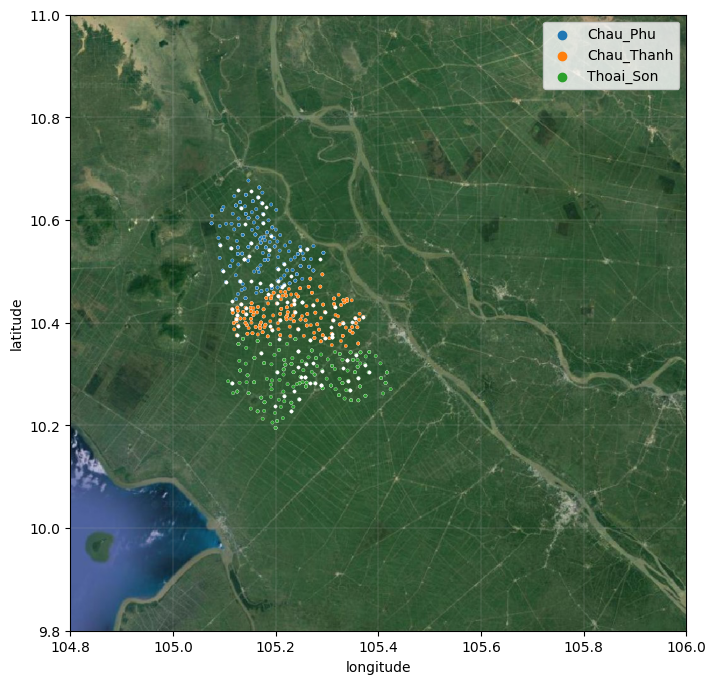

In [180]:
sns.scatterplot(data=crop_yield_data, x='longitude', y='latitude', hue='district', s=6)
sns.scatterplot(data=sub_sample, x='longitude', y='latitude', color='white', s=6)


fig = plt.gcf()
ax  = plt.gca()

fig.set_size_inches(8, 8)

ax.set_aspect('equal')
ax.patch.set_alpha(0)
plt.grid(lw=0.15)
plt.legend()
# legend.legendHandles[0]._sizes = [40]
# legend.legendHandles[1]._sizes = [40]
# legend.set_alpha(0)

plt.xlim(104.8, 106)
plt.ylim(9.8, 11)

# [0.06, 0, 0.95, 0.95]

newax = fig.add_axes(ax.get_position(), anchor='SW', zorder=-15)
# newax.set_position(ax.get_position())
newax.imshow(plt.imread('../Full Region no labels.jpg'), aspect='auto')
newax.axis('off')
# ax.set_xlim(105.3338 - 10**-2/2, 105.3338+ 10**-2/2)
# ax.set_ylim(10.4391  - 10**-2/2, 10.4391 + 10**-2/2)
# newax.set_xlim(105.3338 - 10**-2/2, 105.3338+ 10**-2/2)
# newax.set_ylim(10.4391  - 10**-2/2, 10.4391 + 10**-2/2)
plt.grid(False)

# Process Data

## Constant Features

<AxesSubplot:>

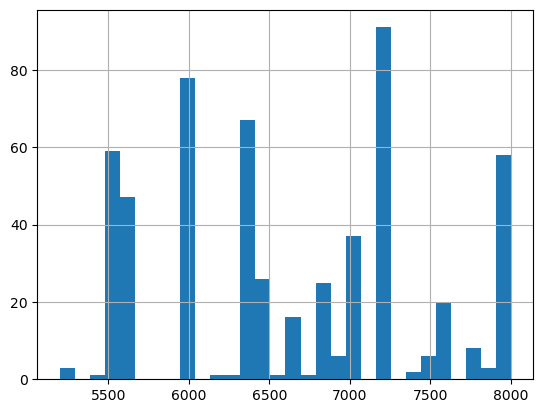

In [181]:
crop_yield_data['rice_yield'].hist(bins=30)

<AxesSubplot:>

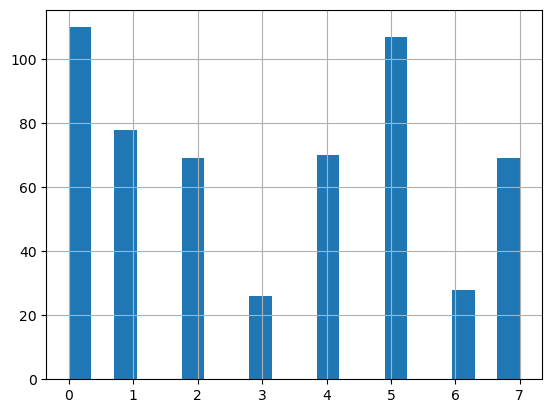

In [182]:
crop_yield_data['target_class'] = pd.qcut(crop_yield_data['rice_yield'], q=8, labels=False)
crop_yield_data['target_class'].hist(bins=20)

In [183]:
crop_yield_data.head(2)

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield,target_class
0,Chau_Phu,10.510542,105.248554,SA,T,2022-07-15,3.40,5500,0
1,Chau_Phu,10.509150,105.265098,SA,T,2022-07-15,2.43,6000,1


In [184]:
train_const_data = pd.get_dummies(crop_yield_data.drop(['district'], axis=1), drop_first=True).drop(['latitude', 'longitude'], axis=1)
sub_const_data   = pd.get_dummies(sub_sample.drop(['district', 'rice_yield', 'id'], axis=1), drop_first=True).drop(['latitude', 'longitude'], axis=1)
display(train_const_data.head(2), sub_const_data.head(2))

,date_of_harvest,field_size,rice_yield,target_class,season_WS,intensity_T
0,2022-07-15,3.40,5500,0,0,1
1,2022-07-15,2.43,6000,1,0,1


,date_of_harvest,field_size,season_WS,intensity_T
0,2022-10-04,1.40,1,1
1,2022-07-15,1.32,0,1


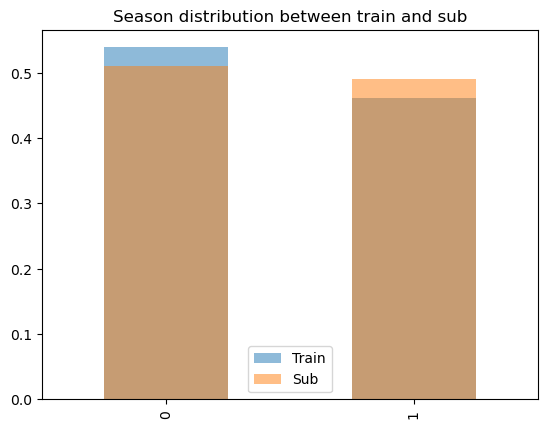

In [185]:
train_const_data.season_WS.value_counts(normalize=True).plot.bar(alpha=0.5, label='Train')
sub_const_data.season_WS.value_counts(normalize=True).plot.bar(alpha=0.5, color='C1', label='Sub')
plt.title('Season distribution between train and sub')
plt.legend();

In [186]:
train_const_data['start_of_harvest']     = train_const_data.date_of_harvest - pd.to_timedelta('100d')
sub_const_data  ['start_of_harvest']     = sub_const_data.date_of_harvest -   pd.to_timedelta('100d')
train_const_data['dayofyear_of_harvest'] = train_const_data.date_of_harvest.dt.day_of_year
sub_const_data['dayofyear_of_harvest']   = sub_const_data.date_of_harvest.dt.day_of_year
display(train_const_data.head(2), sub_const_data.head(2))

,date_of_harvest,field_size,rice_yield,target_class,season_WS,intensity_T,start_of_harvest,dayofyear_of_harvest
0,2022-07-15,3.40,5500,0,0,1,2022-04-06,196
1,2022-07-15,2.43,6000,1,0,1,2022-04-06,196


,date_of_harvest,field_size,season_WS,intensity_T,start_of_harvest,dayofyear_of_harvest
0,2022-10-04,1.40,1,1,2022-06-26,277
1,2022-07-15,1.32,0,1,2022-04-06,196


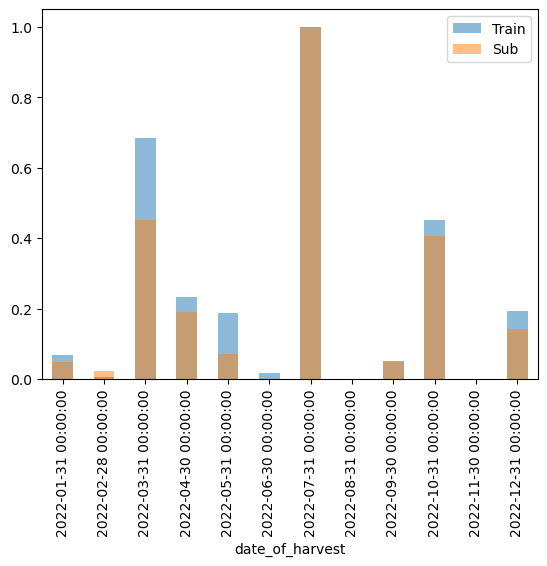

<AxesSubplot:>

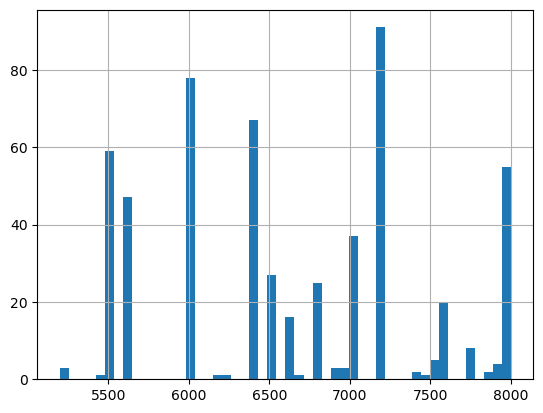

In [187]:
train_const_data.set_index('date_of_harvest').resample('m').count().apply(lambda x:x/x.max()).iloc[:, 0].plot.bar(alpha=0.5, label='Train')
sub_const_data.set_index('date_of_harvest').resample('m').count().apply(lambda x:x/x.max()).iloc[:, 0].plot.bar(alpha=0.5, color='C1', label='Sub')
plt.legend()
plt.show()
train_const_data.rice_yield.hist(bins=50)

In [188]:
# sns.kdeplot(data=train_const_data, x='date_of_harvest', y='rice_yield', hue='intensity_T', levels=8, fill=True, alpha=0.5)
# plt.title('Yield by date and by intensity')

In [189]:
# sns.heatmap(train_const_data.corr(), cmap='coolwarm', annot=True)

In [190]:
# sns.pairplot(train_const_data)

In [191]:
# sns.pairplot(sub_const_data)

## Time Series features

In [192]:
train_ts_data = pd.read_csv('train_data_level2.csv', index_col=['index', 'datetime'], parse_dates=True)
sub_ts_data   = pd.read_csv('sub_data_level2.csv'  , index_col=['index', 'datetime'], parse_dates=True)
# train_sent2_data = pd.read_csv('train_sentinel2_level2_fix.csv', index_col=['index', 'datetime'], parse_dates=True).drop('SCL', axis=1).replace(0, np.nan)
# sub_sent2_data = pd.read_csv('sub_sentinel2_level2.csv', index_col=['index', 'datetime'], parse_dates=True).drop('SCL', axis=1).replace(0, np.nan)

train_sent2_data = pd.read_pickle('../level2_sent2_train.df')
sub_sent2_data   = pd.read_pickle('../level2_sent2_sub.df'  )

display(train_ts_data.head(2), train_sent2_data.head(2), sub_sent2_data.head(2))

vh        vv       rvi
index datetime                                                
0     2021-09-05 22:45:35.619475  0.006411  0.036697  0.229400
      2021-09-11 22:46:08.311308  0.019033  0.295205  0.059627

red                                      \
                                  mean  median percentile_20 percentile_80   
  time                                                                       
0 2022-02-19 03:17:49.024  1739.746704  1636.0   1371.800049   2119.199951   
  2022-02-24 03:17:31.024          NaN     NaN           NaN           NaN   

                                             green                        \
                                  std         mean  median percentile_20   
  time                                                                     
0 2022-02-19 03:17:49.024  418.384033  2018.902222  1910.0   1629.800049   
  2022-02-24 03:17:31.024         NaN          NaN     NaN           NaN   

                                                     ...      rededge          \
                          percentile_80         std  ...         mean  median   
  time                                               ...                        
0 2022-02-19 03:17:49.024   2395.199951  439.676971  ...  2258.773438  2158.0   
  2022-02-24 03:17:31.024           NaN         NaN  ...          NaN     NaN   

                                                                       swir16  \
                          percentile_20 percentile_80        std         mean   
  time                                                                          
0 2022-02-19 03:17:49.024   1842.800049   2661.199951  478.83286  3002.666748   
  2022-02-24 03:17:31.024           NaN           NaN        NaN          NaN   

                                                                           
                           median percentile_20 percentile_80         std  
  time                                                                     
0 2022-02-19 03:17:49.024  2915.0        2506.0        3503.0  562.331221  
  2022-02-24 03:17:31.024     NaN           NaN           NaN         NaN  

[2 rows x 30 columns]

red                                        green  \
                          mean median percentile_20 percentile_80 std  mean   
  time                                                                        
0 2021-11-11 03:19:49.024  NaN    NaN           NaN           NaN NaN   NaN   
  2021-11-16 03:20:11.024  NaN    NaN           NaN           NaN NaN   NaN   

                                                                  ... rededge  \
                          median percentile_20 percentile_80 std  ...    mean   
  time                                                            ...           
0 2021-11-11 03:19:49.024    NaN           NaN           NaN NaN  ...     NaN   
  2021-11-16 03:20:11.024    NaN           NaN           NaN NaN  ...     NaN   

                                                                 swir16  \
                          median percentile_20 percentile_80 std   mean   
  time                                                                    
0 2021-11-11 03:19:49.024    NaN           NaN           NaN NaN    NaN   
  2021-11-16 03:20:11.024    NaN           NaN           NaN NaN    NaN   

                                                                  
                          median percentile_20 percentile_80 std  
  time                                                            
0 2021-11-11 03:19:49.024    NaN           NaN           NaN NaN  
  2021-11-16 03:20:11.024    NaN           NaN           NaN NaN  

[2 rows x 30 columns]

In [193]:
# Add ratio vv/vh
# train_ts_data = train_ts_data.assign(ratio=lambda x:x['vv']/x['vh']/10)
# sub_ts_data = sub_ts_data.assign(ratio=lambda x:x['vv']/x['vh']/10)
# display(train_ts_data.head(2), sub_ts_data.head(2))

# Add Indices to Sentinel 2
def AddBands(sent2_data, multiindex):
    if multiindex:
        sent2_data = sent2_data.stack()
    sent2_data = sent2_data.assign(ndvi =lambda x:(x.nir-x.red)/(x.nir+x.red),
                                           ndwi =lambda x:(x.nir-x.swir16)/(x.nir+x.swir16),
                                           ndbsi=lambda x:((x.nir+x.blue)-(x.red+x.swir16))/((x.nir+x.blue)+(x.red+x.swir16)),
                                           ndre =lambda x:(x.nir-x.rededge)/(x.nir+x.rededge))
    if multiindex:
        sent2_data = sent2_data.unstack()
    return sent2_data

train_sent2_data = AddBands(train_sent2_data, True)
sub_sent2_data = AddBands(sub_sent2_data, True)
display(train_sent2_data.head(), sub_sent2_data)

red                                      \
                                  mean  median percentile_20 percentile_80   
  time                                                                       
0 2022-02-19 03:17:49.024  1739.746704  1636.0   1371.800049   2119.199951   
  2022-03-01 03:16:49.024  1379.891968  1322.0   1280.000000   1396.000000   
  2022-03-06 03:16:21.024  1879.927734  1861.0   1655.400024   2108.399902   
  2022-03-11 03:15:39.024  1553.612183  1505.0   1466.000000   1557.000000   
  2022-03-21 03:15:39.024  2543.598389  2542.0   2453.199951   2630.800049   

                                             green                        \
                                  std         mean  median percentile_20   
  time                                                                     
0 2022-02-19 03:17:49.024  418.384033  2018.902222  1910.0   1629.800049   
  2022-03-01 03:16:49.024  176.871884  1617.362915  1583.0   1536.000000   
  2022-03-06 03:16:21.024  233.633013  2139.688965  2123.0   1895.599976   
  2022-03-11 03:15:39.024  163.240873  1814.518066  1802.0   1753.000000   
  2022-03-21 03:15:39.024   95.326092  2744.618408  2730.0   2642.000000   

                                                     ...     ndbsi            \
                          percentile_80         std  ...      mean    median   
  time                                               ...                       
0 2022-02-19 03:17:49.024   2395.199951  439.676971  ...  0.188546  0.200738   
  2022-03-01 03:16:49.024   1636.000000  130.023945  ...  0.219237  0.233042   
  2022-03-06 03:16:21.024   2396.000000  259.716361  ...  0.166599  0.171678   
  2022-03-11 03:15:39.024   1844.000000  102.726283  ...  0.204221  0.215649   
  2022-03-21 03:15:39.024   2838.800049  106.935856  ...  0.090821  0.092596   

                                                                     ndre  \
                          percentile_20 percentile_80       std      mean   
  time                                                                      
0 2022-02-19 03:17:49.024      0.197558      0.185672  0.158928  0.385165   
  2022-03-01 03:16:49.024      0.214354      0.239946  0.397489  0.408601   
  2022-03-06 03:16:21.024      0.171422      0.169117  0.236652  0.299654   
  2022-03-11 03:15:39.024      0.197877      0.225900  0.390298  0.358038   
  2022-03-21 03:15:39.024      0.090771      0.089742  0.104938  0.144298   

                                                                           
                             median percentile_20 percentile_80       std  
  time                                                                     
0 2022-02-19 03:17:49.024  0.405346      0.401727      0.385773  0.310888  
  2022-03-01 03:16:49.024  0.420495      0.407080      0.426566  0.630296  
  2022-03-06 03:16:21.024  0.306382      0.315529      0.291290  0.269793  
  2022-03-11 03:15:39.024  0.365075      0.346675      0.378261  0.699579  
  2022-03-21 03:15:39.024  0.147689      0.147615      0.140649  0.072018  

[5 rows x 50 columns]

red                                      \
                                   mean  median percentile_20 percentile_80   
   time                                                                       
0  2021-11-21 03:20:29.024   785.581970   647.0    539.599976    990.000000   
   2021-11-26 03:20:51.024   615.453674   567.5    466.200000    688.000000   
   2021-12-06 03:21:21.024  1065.006226  1142.0    712.200000   1347.600000   
   2021-12-21 03:21:39.024   846.475708   819.5    694.400024    980.799988   
   2021-12-26 03:21:41.024  1336.496582  1050.0    774.000000   1604.400024   
...                                 ...     ...           ...           ...   
99 2022-03-26 03:15:41.024  3024.988281  3216.0   2300.000000   3813.199951   
   2022-04-05 03:15:41.024  2015.862549  1936.5   1787.200000   2207.600000   
   2022-04-10 03:15:39.024  2433.467773  2391.0   2274.800000   2593.200000   
   2022-03-06 03:16:21.024  1681.395874  1630.0   1572.000000   1711.000000   
   2022-02-09 03:18:59.024  1348.318726  1271.0   1252.200000   1329.600000   

                                              green                        \
                                   std         mean  median percentile_20   
   time                                                                     
0  2021-11-21 03:20:29.024  356.870019  1120.023438  1012.0    871.000000   
   2021-11-26 03:20:51.024  258.487146   846.700623   819.5    693.000000   
   2021-12-06 03:21:21.024  333.337109  1036.333374  1044.0    812.800000   
   2021-12-21 03:21:39.024  212.280350   802.090271   755.0    654.200012   
   2021-12-26 03:21:41.024  835.844666  1344.802734  1064.0    808.000000   
...                                ...          ...     ...           ...   
99 2022-03-26 03:15:41.024  764.741084  2697.560303  2770.0   2350.399902   
   2022-04-05 03:15:41.024  315.949495  1834.710571  1772.5   1640.200000   
   2022-04-10 03:15:39.024  194.738197  2386.187256  2354.0   2276.400000   
   2022-03-06 03:16:21.024  250.163873  2101.058594  2086.0   1988.000000   
   2022-02-09 03:18:59.024  271.201715  1626.289429  1574.0   1534.000000   

                                                      ...     ndbsi            \
                           percentile_80         std  ...      mean    median   
   time                                               ...                       
0  2021-11-21 03:20:29.024   1347.599976  351.577141  ...  0.239253  0.258863   
   2021-11-26 03:20:51.024    971.800000  229.402724  ...  0.202064  0.210376   
   2021-12-06 03:21:21.024   1241.600000  260.758919  ...  0.071746  0.047792   
   2021-12-21 03:21:39.024    897.799988  217.616641  ...  0.070435  0.052741   
   2021-12-26 03:21:41.024   1602.400024  804.181620  ...  0.084999  0.096749   
...                                  ...         ...  ...       ...       ...   
99 2022-03-26 03:15:41.024   3003.600098  465.918235  ... -0.059089 -0.071546   
   2022-04-05 03:15:41.024   1971.600000  319.541636  ...  0.002082  0.012443   
   2022-04-10 03:15:39.024   2486.000000  158.915718  ...  0.079956  0.082643   
   2022-03-06 03:16:21.024   2172.000000  203.203454  ...  0.211561  0.223011   
   2022-02-09 03:18:59.024   1615.800000  234.827948  ...  0.236107  0.249989   

                                                                      ndre  \
                           percentile_20 percentile_80       std      mean   
   time                                                                      
0  2021-11-21 03:20:29.024      0.221395      0.250563  0.239708  0.442950   
   2021-11-26 03:20:51.024      0.173272      0.233480  0.287501  0.409168   
   2021-12-06 03:21:21.024      0.087430      0.072093  0.080105  0.278946   
   2021-12-21 03:21:39.024      0.124406      0.057354  0.024704  0.139606   
   2021-12-26 03:21:41.024      0.170750      0.059628 -0.011218  0.101231   
...                                  ...           ...       ...       ...   
99 2022-03-26

In [194]:
# Drop a column
# train_sent2_data = train_sent2_data.drop(['red', 'green', 'blue'], axis=1)
# sub_sent2_data = sub_sent2_data.drop(['red', 'green', 'blue'], axis=1)

# display(train_sent2_data.head(2), sub_sent2_data.head(2))

In [195]:
def is_outlier(series, factor=1, print_range=False):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR*factor
    upper_bound = Q3 + 1.5 * IQR*factor
    if print_range:
        print(upper_bound, lower_bound)
    boolean_filter = (series < lower_bound) | (series > upper_bound)
    return pd.Series(np.where(boolean_filter,
                                       np.nan,
                                       series),
                              index=series.index)

In [196]:
# Transformación de variables sentinel 1
train_ts_data[['vv', 'vh']] = train_ts_data[['vv', 'vh']].apply(lambda x:np.log10(x))
train_ts_data['rvi'] = train_ts_data['rvi'].apply(lambda x:np.log10(x))
sub_ts_data[['vv', 'vh']] = sub_ts_data[['vv', 'vh']].apply(lambda x:np.log10(x))
sub_ts_data['rvi'] = sub_ts_data['rvi'].apply(lambda x:np.log10(x))

In [197]:
# Transformación de variables sentinel 2
# train_sent2_data.loc[:, 'red,green,blue,nir,rededge,swir16'.split(',')] = train_sent2_data['red,green,blue,nir,rededge,swir16'.split(',')].apply(lambda x:np.log10(x))
# sub_sent2_data.loc[  :, 'red,green,blue,nir,rededge,swir16'.split(',')] = sub_sent2_data[  'red,green,blue,nir,rededge,swir16'.split(',')].apply(lambda x:np.log10(x))

In [198]:
# Check boxplot with different outliers filters
# train_ts_data.plot.box()
# sub_ts_data.plot.box()
# train_sent2_data.plot.box()
# sub_sent2_data.plot.box()

In [199]:
train_ts_data    = train_ts_data.apply(is_outlier, args=[10])
sub_ts_data      = sub_ts_data.apply(  is_outlier, args=[10])
train_sent2_data = train_sent2_data.apply(is_outlier, args=[10])
sub_sent2_data   = sub_sent2_data.apply(is_outlier, args=[10])

In [200]:
# Check boxplot after outlier filters
# train_ts_data.plot.box()
# sub_ts_data.plot.box()
# train_sent2_data.plot.box()
# sub_sent2_data.plot.box()

### Slicing time frame

In [201]:
train_ts_data    = train_ts_data.unstack(    level=0).resample('1d').mean().stack(dropna=False).swaplevel().sort_index(level=0)
sub_ts_data      = sub_ts_data.unstack(      level=0).resample('1d').mean().stack(dropna=False).swaplevel().sort_index(level=0)

train_sent2_data  = train_sent2_data.unstack(level=0).resample('1d').mean().stack(dropna=False).swaplevel().sort_index(level=0)
sub_sent2_data    = sub_sent2_data.unstack(  level=0).resample('1d').mean().stack(dropna=False).swaplevel().sort_index(level=0)

In [202]:
# Create slices to keep only 100 days prior to harvest for each coordinate

# Get high rice yields index
idx_high = crop_yield_data[crop_yield_data.rice_yield >= 7200].index

harvest_slices = []
for idx in range(len(train_ts_data.index.levels[0])):
    harvest_slices.append((idx, slice(train_const_data.loc[idx, 'start_of_harvest'], train_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(train_ts_data.loc[hs, :])
    
# Concatenate slices
train_ts_data = pd.concat(data_slices)

# Create slices to keep only 100 days prior to harvest for each coordinate
harvest_slices = []
for idx in range(len(train_sent2_data.index.levels[0])):
    harvest_slices.append((idx, slice(train_const_data.loc[idx, 'start_of_harvest'], train_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(train_sent2_data.loc[hs, :])
    
# Concatenate slices
train_sent2_data = pd.concat(data_slices)

# Sub
harvest_slices = []
for idx in range(len(sub_ts_data.index.levels[0])):
    harvest_slices.append((idx, slice(sub_const_data.loc[idx, 'start_of_harvest'], sub_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(sub_ts_data.loc[hs, :])
    
# Concatenate slices
sub_ts_data = pd.concat(data_slices)

# Sub
harvest_slices = []
for idx in range(len(sub_sent2_data.index.levels[0])):
    harvest_slices.append((idx, slice(sub_const_data.loc[idx, 'start_of_harvest'], sub_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(sub_sent2_data.loc[hs, :])
    
# Concatenate slices
sub_sent2_data = pd.concat(data_slices)

In [203]:
train_ts_data = pd.concat([train_ts_data, train_sent2_data], axis=1)
sub_ts_data   = pd.concat([sub_ts_data   , sub_sent2_data] , axis=1)

In [204]:
def ResampleMultiIndex(df):
    level_values = df.index.get_level_values
    return df.groupby([level_values(0)]+[pd.Grouper(freq='5d', level=1)]).median().interpolate().bfill().rolling(5).median().bfill()

train_ts_data = ResampleMultiIndex(train_ts_data)
sub_ts_data = ResampleMultiIndex(sub_ts_data)

In [205]:
# train_ts_data = train_ts_data.unstack(level=0).resample('1w').mean().stack().swaplevel().sort_index()
# sub_ts_data = sub_ts_data.unstack(level=0).resample('1w').mean().stack().swaplevel().sort_index()

# train_sent2_data = train_sent2_data.unstack(level=0).resample('1w').mean().stack().swaplevel().sort_index()
# sub_sent2_data = sub_sent2_data.unstack(level=0).resample('1w').mean().stack().swaplevel().sort_index()

In [206]:
# interpolate all datetimes
# # for that we unstack the index, do the interpolation, then restack
# train_ts_data    = train_ts_data.unstack(level=0).interpolate().bfill().ffill().rolling(7).mean().bfill().stack().swaplevel().sort_index(level=0)
# sub_ts_data      = sub_ts_data.unstack(  level=0).interpolate().bfill().ffill().rolling(7).mean().bfill().stack().swaplevel().sort_index(level=0)

# train_sent2_data = train_sent2_data.unstack(level=0).interpolate().bfill().ffill().rolling(7).mean().dropna(how='all').stack().swaplevel().sort_index(level=0)
# sub_sent2_data = sub_sent2_data.unstack(level=0).interpolate().bfill().ffill().rolling(7).mean().dropna(how='all').stack().swaplevel().sort_index(level=0)

display(train_ts_data.head(2), sub_ts_data.head(2))

vh        vv      rvi  (red, mean)  (red, median)  \
0 2022-04-04 -1.493011 -0.826427 -0.52726  2199.946655         2161.5   
  2022-04-09 -1.493011 -0.826427 -0.52726  2199.946655         2161.5   

              (red, percentile_20)  (red, percentile_80)  (red, std)  \
0 2022-04-04                2060.0           2344.199951  196.254489   
  2022-04-09                2060.0           2344.199951  196.254489   

              (green, mean)  (green, median)  ...  (ndbsi, mean)  \
0 2022-04-04    2184.617554           2167.0  ...         0.0413   
  2022-04-09    2184.617554           2167.0  ...         0.0413   

              (ndbsi, median)  (ndbsi, percentile_20)  (ndbsi, percentile_80)  \
0 2022-04-04         0.058685                0.058906                0.028363   
  2022-04-09         0.058685                0.058906                0.028363   

              (ndbsi, std)  (ndre, mean)  (ndre, median)  \
0 2022-04-04     -0.155239     -0.003012       -0.001773   
  2022-04-09     -0.155239     -0.003012       -0.001773   

              (ndre, percentile_20)  (ndre, percentile_80)  (ndre, std)  
0 2022-04-04              -0.033532               0.022036     0.250434  
  2022-04-09              -0.033532               0.022036     0.250434  

[2 rows x 53 columns]

vh        vv       rvi  (red, mean)  (red, median)  \
0 2022-06-23 -1.542592 -0.992491 -0.430987       3199.5         3209.0   
  2022-06-28 -1.542592 -0.992491 -0.430987       3199.5         3209.0   

              (red, percentile_20)  (red, percentile_80)  (red, std)  \
0 2022-06-23           3165.600098           3237.199951   51.546096   
  2022-06-28           3165.600098           3237.199951   51.546096   

              (green, mean)  (green, median)  ...  (ndbsi, mean)  \
0 2022-06-23         2958.0           2961.0  ...       0.117392   
  2022-06-28         2958.0           2961.0  ...       0.117392   

              (ndbsi, median)  (ndbsi, percentile_20)  (ndbsi, percentile_80)  \
0 2022-06-23         0.125995                0.128899                0.109634   
  2022-06-28         0.125995                0.128899                0.109634   

              (ndbsi, std)  (ndre, mean)  (ndre, median)  \
0 2022-06-23     -0.492948     -0.036801       -0.039183   
  2022-06-28     -0.492948     -0.036801       -0.039183   

              (ndre, percentile_20)  (ndre, percentile_80)  (ndre, std)  
0 2022-06-23              -0.037201               -0.03735     0.113818  
  2022-06-28              -0.037201               -0.03735     0.113818  

[2 rows x 53 columns]

62


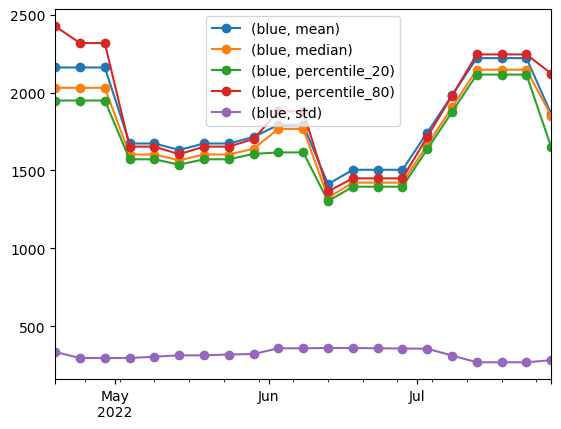

78


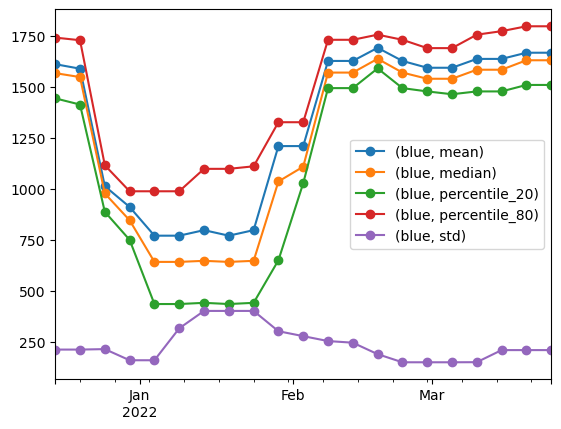

In [207]:
# Visualize data for one random sample
rand = np.random.randint(idx_high.to_series().sample().values[0])
print(rand)
train_ts_data.loc[rand].filter(like='blue').plot(marker='o')
# [plt.axvline(train_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];
plt.show();

# Visualize data for one random sample
rand = np.random.randint(0, 99)
print(rand)
sub_ts_data.loc[rand].filter(like='blue').plot(marker='o')
# [plt.axvline(sub_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];
plt.show();

# # Visualize data for one random sample
# rand = np.random.randint(idx_high.to_series().sample().values[0])
# print(rand)
# train_sent2_data.loc[rand].filter(like='blue').plot(color=['r', 'g', 'b', 'crimson', 'tomato', 'skyblue'], marker='o')
# # [plt.axvline(train_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];
# plt.show();

# # Visualize data for one random sample
# rand = np.random.randint(0, 99)
# print(rand)
# sub_sent2_data.loc[78].filter(like='nd').plot(color=['r', 'g', 'b', 'crimson', 'tomato', 'skyblue'], marker='o')
# # [plt.axvline(sub_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];
# plt.show();


### Detect TS Anomalies

In [208]:
from sklearn.preprocessing import StandardScaler
train_ts_data = train_ts_data
train_ts_data.loc[:, :] = StandardScaler().fit_transform(train_ts_data)
sub_ts_data = sub_ts_data
sub_ts_data.loc[:, :] = StandardScaler().fit_transform(sub_ts_data)

In [209]:
import torch
import torch.nn as nn

# Define a simple RNN model with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Feed input sequence through the LSTM
        out, _ = self.rnn(x, (h0, c0))

        # Pass the output sequence through a fully connected layer
        out = self.fc(out)

        return out

# Define a loss function that penalizes large deviations from the predicted values
class AnomalyDetectionLoss(nn.Module):
    def __init__(self, threshold):
        super(AnomalyDetectionLoss, self).__init__()
        self.threshold = threshold

    def forward(self, y_pred, y_true):
        errors = torch.abs(y_pred - y_true)
        mask = errors > self.threshold
        loss = torch.mean(torch.where(mask, errors, torch.zeros_like(errors)))
        return loss

# Define a training function that uses an optimizer to minimize the loss
def train_model(model, train_loader, optimizer, loss_fn, num_epochs):
    for epoch in range(num_epochs):
        for i, (inputs) in enumerate(train_loader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, inputs)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()), end='\r')

# Define a function to detect anomalies in a time series
def detect_anomalies(model, data, threshold):
    inputs = torch.Tensor(data)
    outputs = model(inputs)
    print(inputs.shape, outputs.shape)
    errors = torch.abs(outputs - inputs)
    mask = errors > threshold
    return mask.squeeze().detach().cpu().numpy()

# Example usage:
threshold = 3
data = torch.Tensor(np.vstack([train_ts_data.values.reshape(557, 21, -1), sub_ts_data.values.reshape(100, 21, -1)])).to('cuda')
model = RNN(input_size=data.shape[-1], hidden_size=10, output_size=data.shape[-1]).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=10**-4)
loss_fn = AnomalyDetectionLoss(threshold=threshold)
train_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)
train_model(model, train_loader, optimizer, loss_fn, num_epochs=20)

In [210]:
anomaly_mask_train = detect_anomalies(model, data[:557], threshold=threshold*0.35)
anomaly_mask_sub   = detect_anomalies(model, data[557:], threshold=threshold*0.35)

torch.Size([557, 21, 53]) torch.Size([557, 21, 53])
torch.Size([100, 21, 53]) torch.Size([100, 21, 53])


In [211]:
anomaly_mask_train_df = pd.DataFrame(anomaly_mask_train.reshape(train_ts_data.shape), index=train_ts_data.index, columns=train_ts_data.columns)
anomaly_mask_sub_df   = pd.DataFrame(anomaly_mask_sub.reshape(sub_ts_data.shape)  , index=sub_ts_data.index  , columns=sub_ts_data.columns)

In [212]:
# # Join red, blue, green masks, and ndbi, etc, masks
# anomaly_mask_train_df[anomaly_mask_train_df.columns[3:8]] = anomaly_mask_train_df.iloc[:, 3:8].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_train_df.columns[3:8])
# anomaly_mask_train_df[anomaly_mask_train_df.columns[9:]]  = anomaly_mask_train_df.iloc[:, 9: ].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_train_df.columns[9:])
# anomaly_mask_train_df = anomaly_mask_train_df.ffill(axis=1)

# anomaly_mask_sub_df[anomaly_mask_sub_df.columns[3:8]] = anomaly_mask_sub_df.iloc[:, 3:8].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_sub_df.columns[3:8])
# anomaly_mask_sub_df[anomaly_mask_sub_df.columns[9:]]  = anomaly_mask_sub_df.iloc[:, 9: ].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_sub_df.columns[9:])
# anomaly_mask_sub_df = anomaly_mask_sub_df.ffill(axis=1)

In [213]:
iterator = iter(range(0, 50))

0


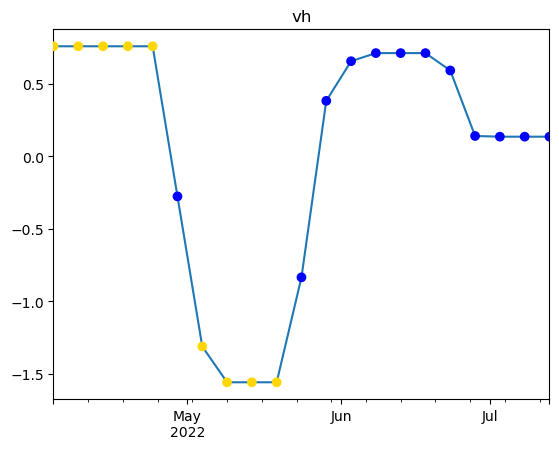

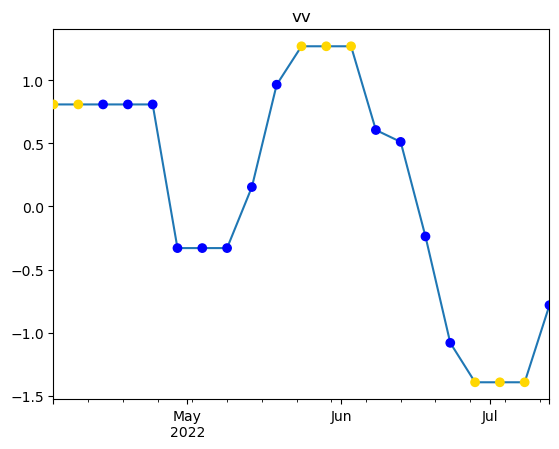

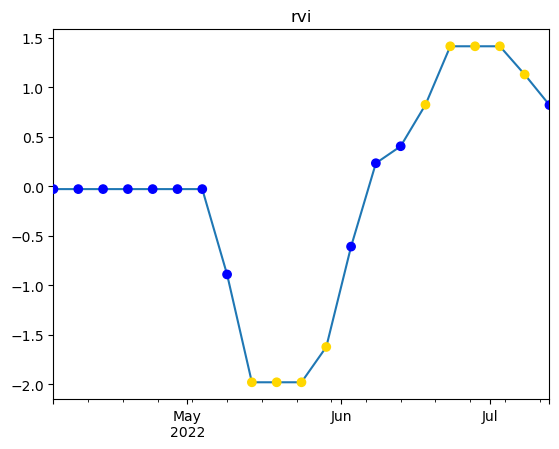

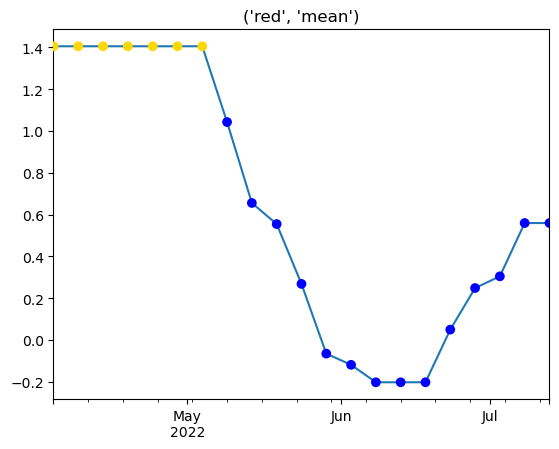

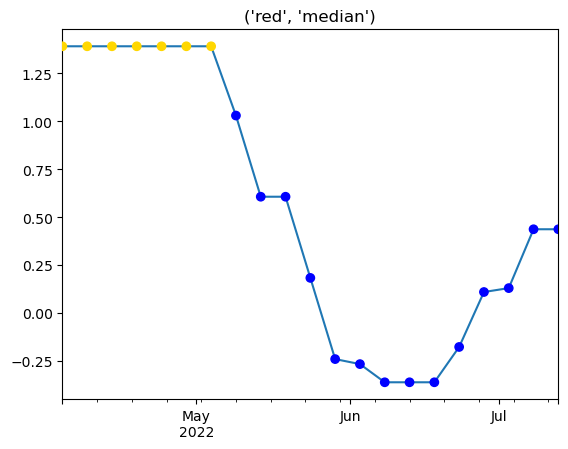

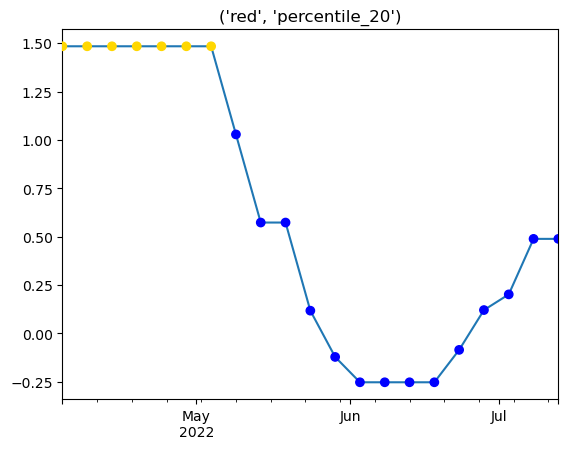

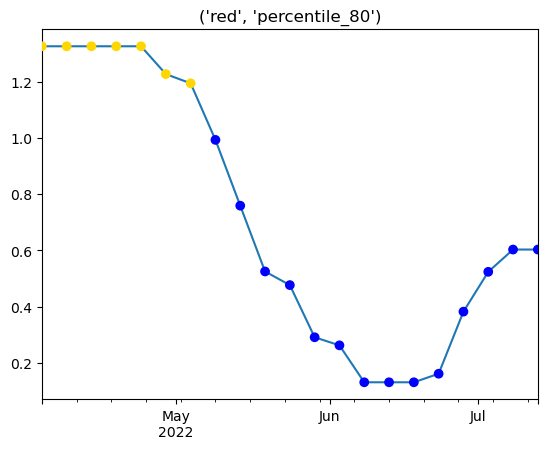

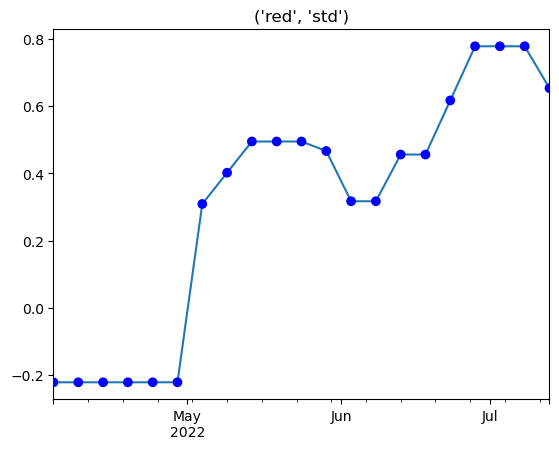

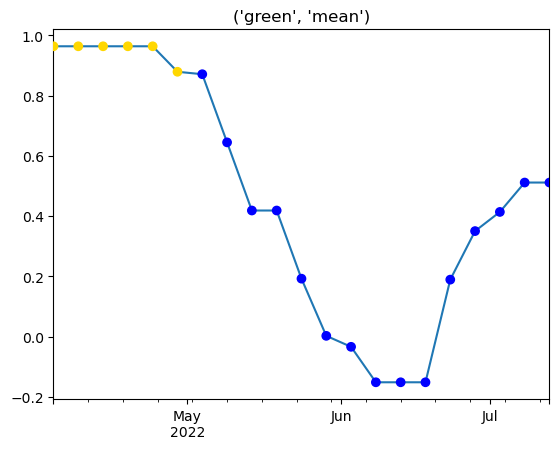

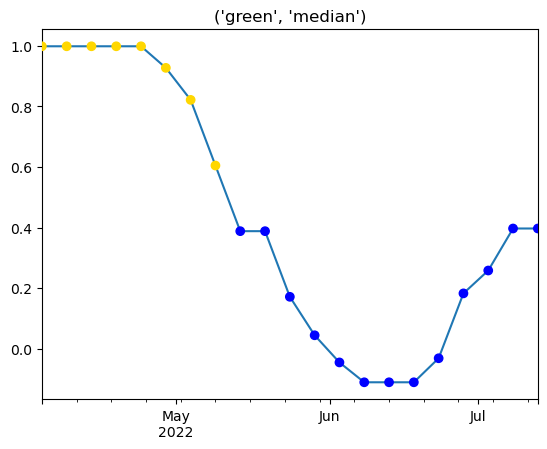

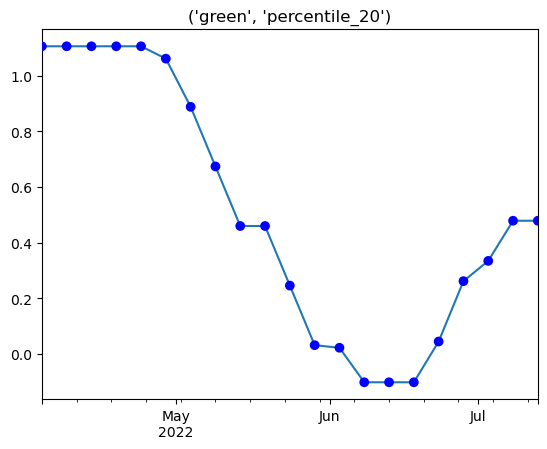

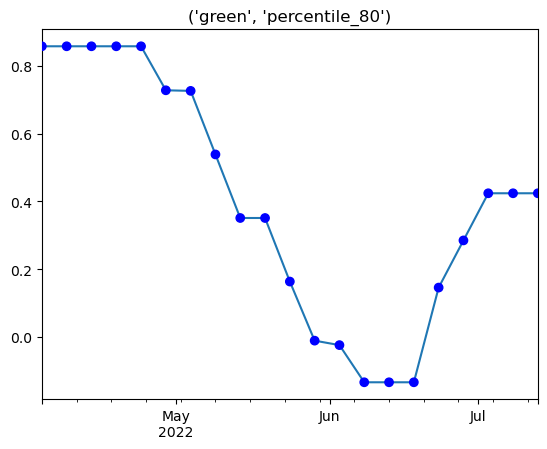

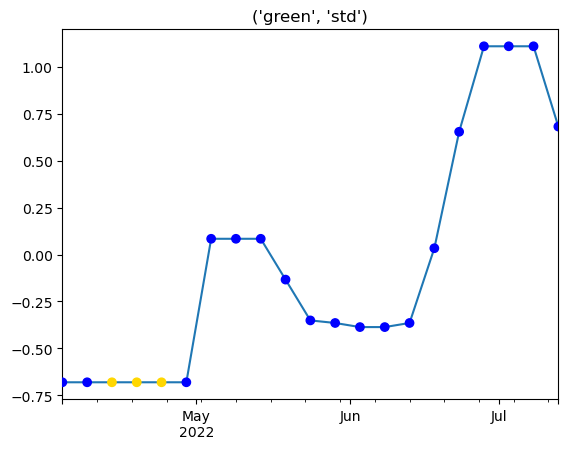

In [214]:
n = next(iterator)
print(n)
# n = 18
# print(pd.DataFrame(anomaly_mask).stack().xs(n))
for f in range(13):
    plt.scatter(y=train_ts_data.iloc[:, f].xs(n).values, x=train_ts_data.iloc[:, f].xs(n).index, color=['gold' if x else 'blue' for x in anomaly_mask_train_df.xs(n).iloc[:, f]], zorder=100)
    train_ts_data.iloc[:, f].xs(n).plot()
    plt.title(train_ts_data.iloc[:, f].name)
    plt.show();

In [215]:
# train_ts_data = train_ts_data.groupby(pd.Grouper(level=0)).apply(lambda x:x.rolling(3).median().bfill())
# sub_ts_data   = sub_ts_data.groupby(pd.Grouper(level=0)).apply(lambda x:x.rolling(3).median().bfill())

In [216]:
# # Fix and then fill nas
# train_ts_data = train_ts_data.groupby(pd.Grouper(level=0)).apply(lambda x:x.interpolate(limit_area='inside').ffill().bfill().fillna(0).rolling(3).median().bfill())
# sub_ts_data   = sub_ts_data.groupby(  pd.Grouper(level=0)).apply(lambda x:x.interpolate(limit_area='inside').ffill().bfill().fillna(0).rolling(3).median().bfill())

1


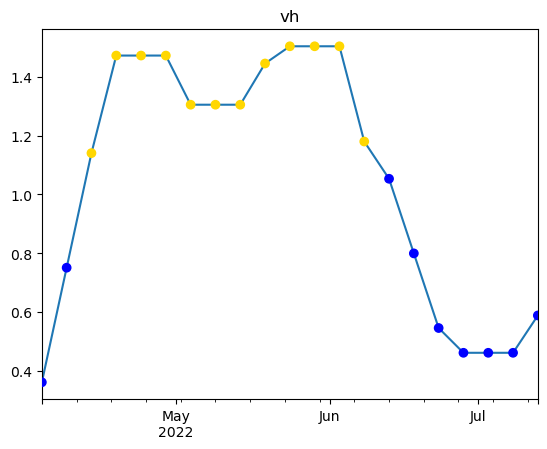

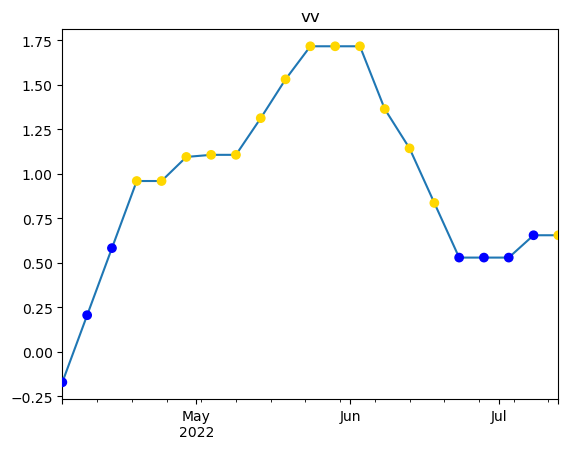

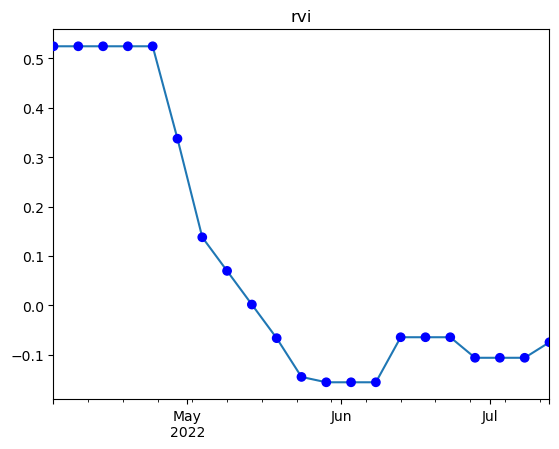

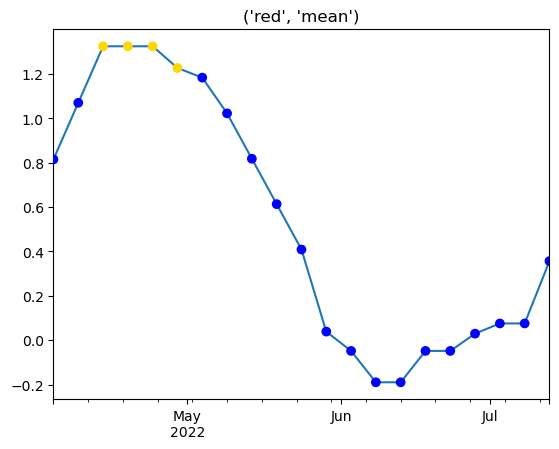

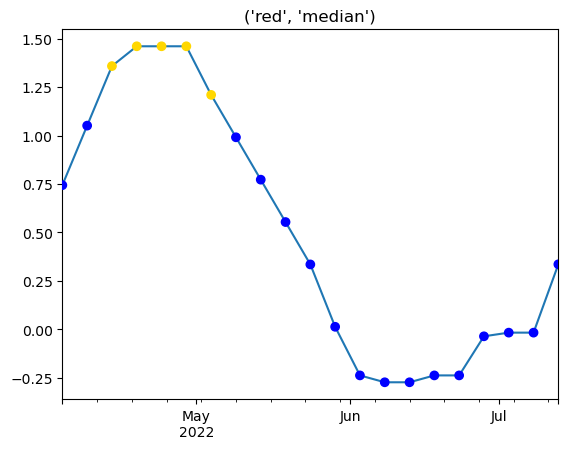

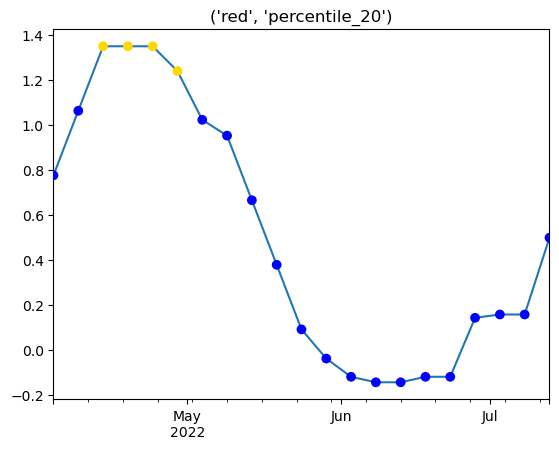

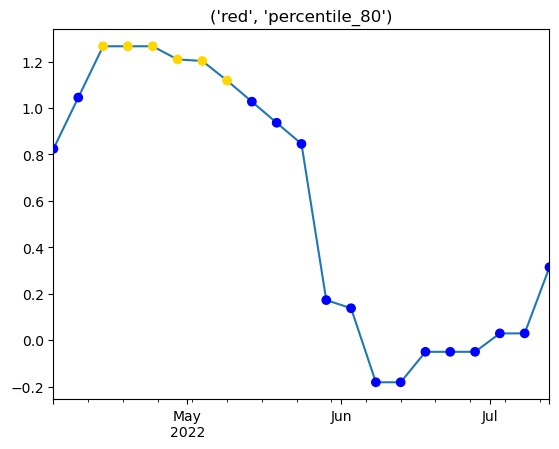

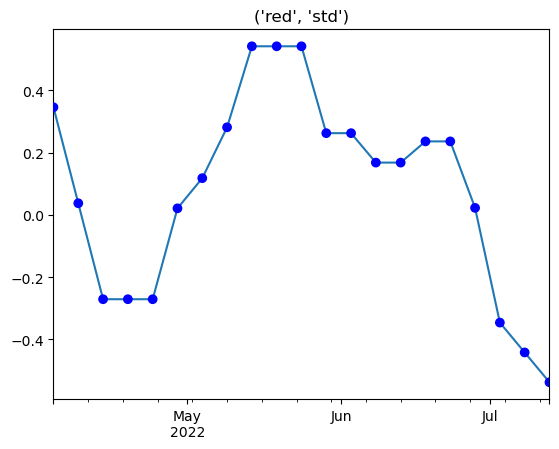

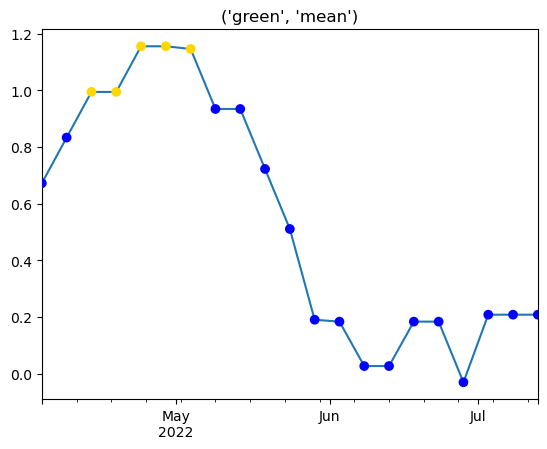

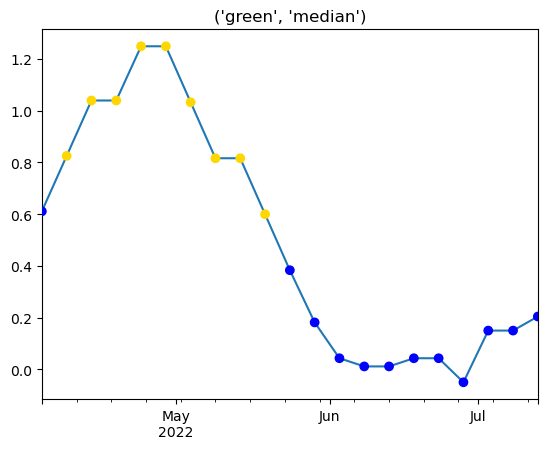

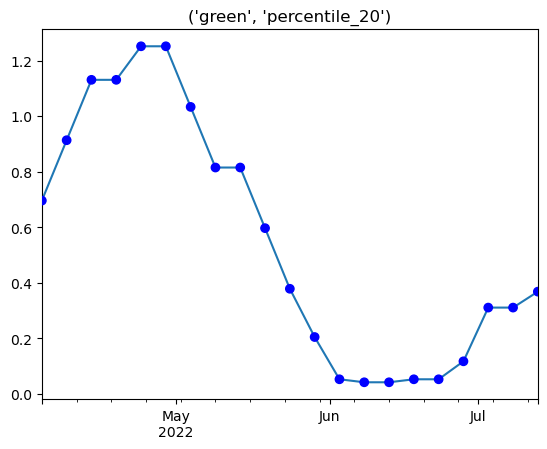

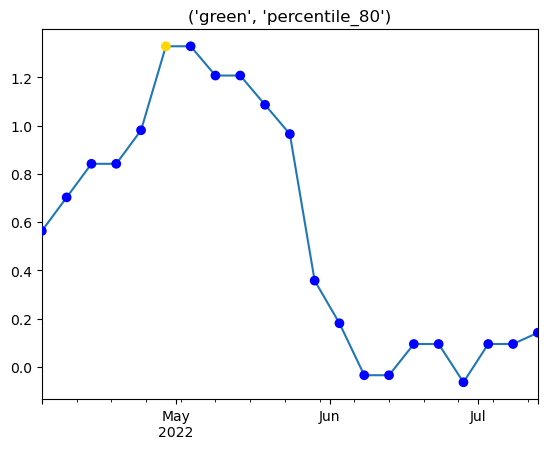

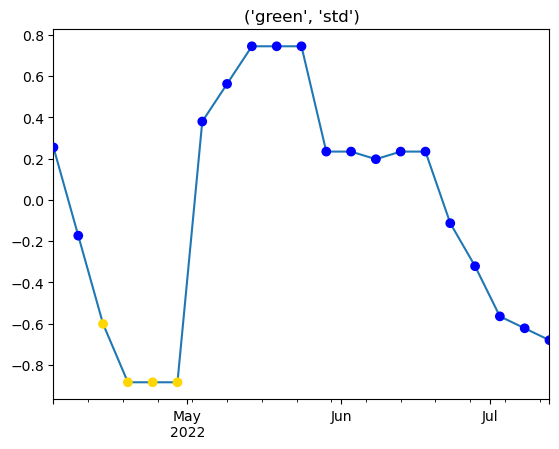

In [217]:
n = next(iterator)
print(n)
n = 1
# print(pd.DataFrame(anomaly_mask).stack().xs(n))
for f in range(13):
    plt.scatter(y=train_ts_data.iloc[:, f].xs(n).values, x=train_ts_data.iloc[:, f].xs(n).index, color=['gold' if x else 'blue' for x in anomaly_mask_train_df.xs(n).iloc[:, f]], zorder=100)
    train_ts_data.iloc[:, f].xs(n).plot()
    plt.title(train_ts_data.iloc[:, f].name)
    plt.show();

In [218]:
# Check that all time_series are the same length
display(train_ts_data.groupby(level=0).count().iloc[:, 0].describe(),
        sub_ts_data.groupby(level=0).count().iloc[:, 0].describe())

count    557.0
mean      21.0
std        0.0
min       21.0
25%       21.0
50%       21.0
75%       21.0
max       21.0
Name: vh, dtype: float64

count    100.0
mean      21.0
std        0.0
min       21.0
25%       21.0
50%       21.0
75%       21.0
max       21.0
Name: vh, dtype: float64

## Extra constant features (time series descriptors)

<p align="justify">
Auto Correlation - Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals. Autocorrelation measures the relationship between a variable's current value and its past values.
</p>

<p align="justify">
Permutation Entropy - Permutation Entropy (PE) is a robust time series tool which provides a quantification measure of the complexity of a dynamic system by capturing the order relations between values of a time series and extracting a probability distribution of the ordinal patterns.
</p>
<p>You are encouraged to identify possible time series metrices that can be used as features.</p>

Tip 5  
Participants can generate other statistical features which are statiscally significant to understand characterstics of rice phenology. There are existing packages available which can generate some of these metrics for you.

In [219]:
def ordinal_distribution(data, dx=3, dy=1, taux=1, tauy=1, return_missing=False, tie_precision=None):
    '''
    Returns
    -------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.
       
    Attributes
    ---------
    data : array 
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`.
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    return_missing: boolean
                    If `True`, it returns ordinal patterns not appearing in the 
                    symbolic sequence obtained from **data** are shown. If `False`,
                    these missing patterns (permutations) are omitted 
                    (default: `False`).
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
   
    '''
    def setdiff(a, b):
        '''
        Returns
        -------
        : array
            An array containing the elements in `a` that are not contained in `b`.
            
        Parameters
        ----------    
        a : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        b : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        '''

        a = np.asarray(a).astype('int64')
        b = np.asarray(b).astype('int64')

        _, ncols = a.shape

        dtype={'names':['f{}'.format(i) for i in range(ncols)],
            'formats':ncols * [a.dtype]}

        C = np.setdiff1d(a.view(dtype), b.view(dtype))
        C = C.view(a.dtype).reshape(-1, ncols)

        return(C)

    try:
        ny, nx = np.shape(data)
        data   = np.array(data)
    except:
        nx     = np.shape(data)[0]
        ny     = 1
        data   = np.array([data])

    if tie_precision is not None:
        data = np.round(data, tie_precision)

    partitions = np.concatenate(
        [
            [np.concatenate(data[j:j+dy*tauy:tauy,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
            for j in range(ny-(dy-1)*tauy)
        ]
    )

    symbols = np.apply_along_axis(np.argsort, 1, partitions)
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

    probabilities = symbols_count/len(partitions)

    if return_missing==False:
        return symbols, probabilities
    
    else:
        all_symbols   = list(map(list,list(itertools.permutations(np.arange(dx*dy)))))
        miss_symbols  = setdiff(all_symbols, symbols)
        symbols       = np.concatenate((symbols, miss_symbols))
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols.__len__())))
        
        return symbols, probabilities

In [220]:
def permutation_entropy(data, dx=3, dy=1, taux=1, tauy=1, base=2, normalized=True, probs=False, tie_precision=None):
    '''
    Returns Permutation Entropy
    Attributes:
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by :func:`ordpy.ordinal_distribution`).
    dx :   int
           Embedding dimension (horizontal axis) (default: 3).
    dy :   int
           Embedding dimension (vertical axis); it must be 1 for time series (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value 
                (default: `True`). If `False`, it is not.
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
    '''
    if not probs:
        _, probabilities = ordinal_distribution(data, dx, dy, taux, tauy, return_missing=False, tie_precision=tie_precision)
    else:
        probabilities = np.asarray(data)
        probabilities = probabilities[probabilities>0]

    if normalized==True and base in [2, '2']:        
        smax = np.log2(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log2(probabilities))
        return s/smax
         
    elif normalized==True and base=='e':        
        smax = np.log(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log(probabilities))
        return s/smax
    
    elif normalized==False and base in [2, '2']:
        return -np.sum(probabilities*np.log2(probabilities))
    else:
        return -np.sum(probabilities*np.log(probabilities))

In [221]:
def generate_stastical_features(dataframe):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    features_list = []
    for index, row in dataframe.iterrows():
        print(row)
        print(row['vv'])
        print(min(row))
        min_vv = min(row['vv'])
        max_vv = max(row['vv'])
        range_vv = max_vv - min_vv
        mean_vv = np.mean(row['vv'])
        correlation_vv = sm.tsa.acf(row['vv'])[1]
        permutation_entropy_vv = permutation_entropy(row[0], dx=6,base=2, normalized=True) 
    
        min_vh = min(row['vh'])
        max_vh = max(row['vh'])
        range_vh = max_vh - min_vh
        mean_vh = np.mean(row['vh'])
        correlation_vh = sm.tsa.acf(row['vh'])[1]
        permutation_entropy_vh = permutation_entropy(row[1], dx=6, base=2, normalized=True)
    
        min_vv_by_vh = min(row['rvi'])
        max_vv_by_vh = max(row['rvi'])
        range_vv_by_vh = max_vv_by_vh - min_vv_by_vh
        mean_vv_by_vh = np.mean(row['rvi'])
        correlation_vv_by_vh = sm.tsa.acf(row['rvi'])[1]
        permutation_entropy_vv_by_vh = permutation_entropy(row[2], dx=6, base=2, normalized=True)
    
        features_list.append([min_vv, max_vv, range_vv, mean_vv, correlation_vv, permutation_entropy_vv,
                          min_vh, max_vh, range_vh,  mean_vh, correlation_vh, permutation_entropy_vh,
                          min_vv_by_vh,  max_vv_by_vh, range_vv_by_vh, mean_vv_by_vh, correlation_vv_by_vh, permutation_entropy_vv_by_vh])
    return features_list

In [222]:
def generate_stastical_features_fix(group):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    out = group.agg(['min', 'max', 'ptp', 'mean'])

    for i in range(1):
        out.loc[f'auto_corr_{i+1}', :] = group.apply(lambda x:sm.tsa.acf(x)[i+1])

    out.loc['permut_entropy', :] = group.apply(lambda x:permutation_entropy(x, dx=6, base=2, normalized=True))
        
    return out

In [223]:
descriptors_train = train_ts_data.groupby(level=0).progress_apply(lambda x:generate_stastical_features_fix(x))
descriptors_sub   = sub_ts_data.groupby  (level=0).progress_apply(lambda x:generate_stastical_features_fix(x))

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [224]:
# multicols_names = descriptors_train.unstack().columns.map('_'.join)

descriptors_train = descriptors_train.unstack().droplevel(0, axis=1)
# descriptors_train.columns = multicols_names
descriptors_sub   = descriptors_sub.unstack().droplevel(0, axis=1)
# descriptors_sub.columns   = multicols_names

display(descriptors_train.head(2), descriptors_sub.head(2))

,min,max,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,...,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,auto_corr_1,permut_entropy
0,-1.560643,0.761223,2.321866,0.048981,0.834157,0.316061,-1.394516,1.270535,2.665051,0.134274,...,2.938233,-0.533592,0.931360,0.170846,-1.599992,1.228642,2.828634,-0.456453,0.845536,0.202679
1,0.360282,1.504856,1.144574,1.052298,0.804789,0.390105,-0.171299,1.715608,1.886907,0.955530,...,2.044368,-0.279014,0.924273,0.233560,-1.009163,0.632534,1.641697,0.062496,0.765402,0.344969


,min,max,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,...,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,auto_corr_1,permut_entropy
0,-2.172865,0.990323,3.163188,-0.286719,0.904703,0.292017,-2.407546,0.350885,2.758431,-0.517198,...,0.000000,-1.931348,0.952381,-0.000000,-1.599257,-1.599257,0.000000,-1.599257,NaN,-0.000000
1,-1.258747,0.694956,1.953702,-0.248363,0.842590,0.331800,-0.729693,1.178324,1.908017,0.009332,...,3.034663,-0.212663,0.915210,0.138148,-1.599257,1.190207,2.789464,0.166934,0.727233,0.390105


In [225]:
train_const_data = pd.concat([train_const_data, descriptors_train], axis=1).drop(['start_of_harvest', 'target_class', 'date_of_harvest'], axis=1)
sub_const_data   = pd.concat([sub_const_data  , descriptors_sub], axis=1).drop(['start_of_harvest', 'date_of_harvest'], axis=1)
train_const_data.head(2)

,field_size,rice_yield,season_WS,intensity_T,dayofyear_of_harvest,min,max,ptp,mean,auto_corr_1,...,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,auto_corr_1,permut_entropy
0,3.40,5500,0,1,196,-1.560643,0.761223,2.321866,0.048981,0.834157,...,2.938233,-0.533592,0.931360,0.170846,-1.599992,1.228642,2.828634,-0.456453,0.845536,0.202679
1,2.43,6000,0,1,196,0.360282,1.504856,1.144574,1.052298,0.804789,...,2.044368,-0.279014,0.924273,0.233560,-1.009163,0.632534,1.641697,0.062496,0.765402,0.344969


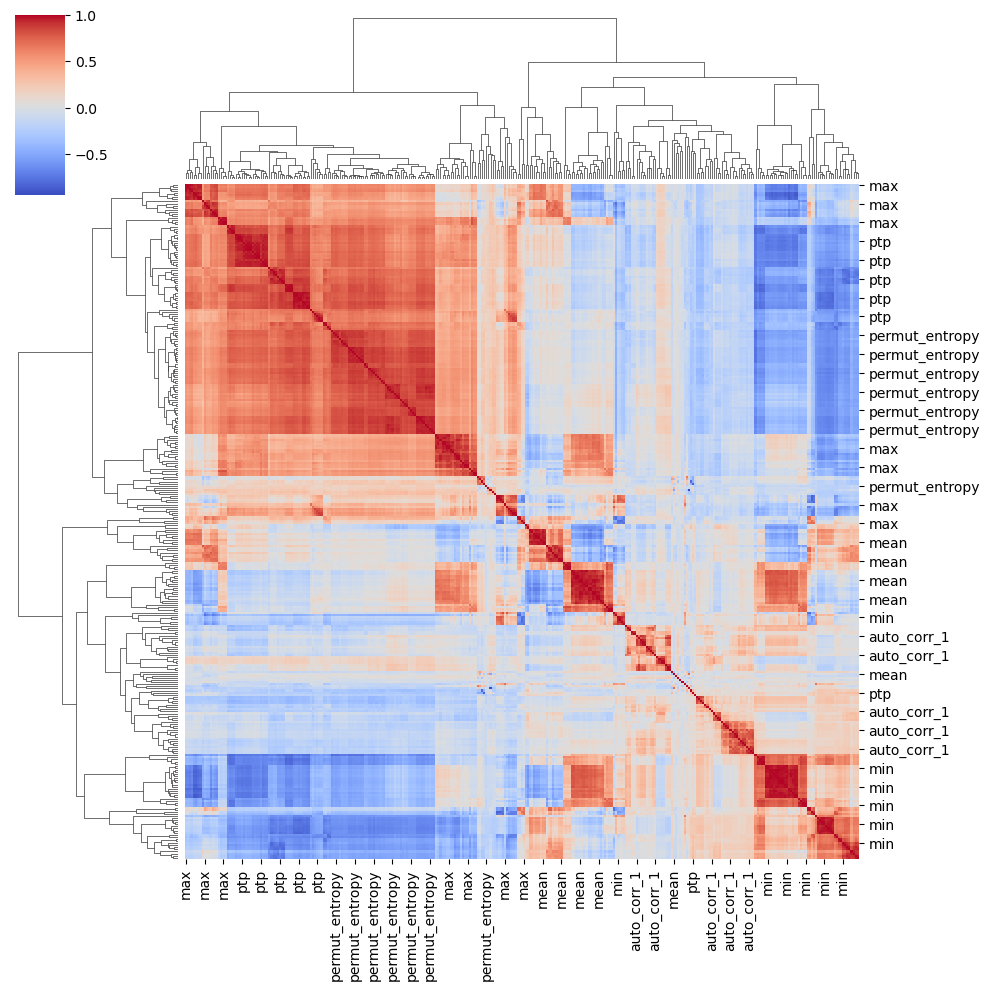

In [226]:
sns.clustermap(train_const_data.corr(), cmap='coolwarm')

In [227]:
train_const_data.isna().sum().sum()
sub_const_data.isna().sum().sum()

33

In [228]:
train_const_data = train_const_data.fillna(0)
sub_const_data   = sub_const_data.fillna(0)

In [229]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_regression
scaler = StandardScaler()
selector = SelectPercentile(f_regression, percentile=75)
selector.fit(scaler.fit_transform(train_const_data.drop('rice_yield', axis=1)), train_const_data.rice_yield)

SelectPercentile(percentile=75,
                 score_func=<function f_regression at 0x7f2beca79700>)

<AxesSubplot:>

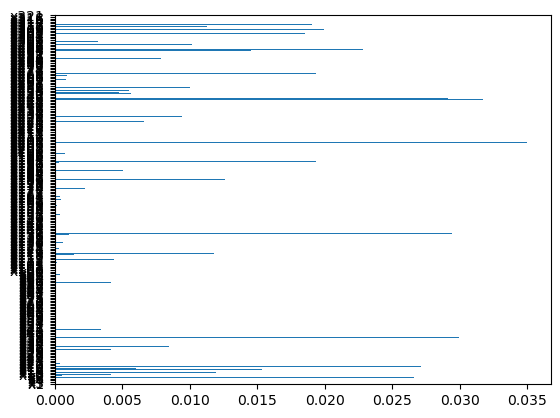

In [230]:
pd.Series(selector.pvalues_[selector.get_support()], index=selector.get_feature_names_out()).plot.barh()

In [231]:
train_const_data_pca = train_const_data.drop('rice_yield', axis=1)
sub_const_data_pca  = sub_const_data

# train_const_data_pca = pd.DataFrame(columns=selector.get_feature_names_out(), data=selector.transform(train_const_data.drop('rice_yield', axis=1)))
# sub_const_data_pca   = pd.DataFrame(columns=selector.get_feature_names_out(), data=selector.transform(sub_const_data))

# Create Model

In [624]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

def TrainTorch(xtrain, ytrain, val_data=(None, None), n_epochs=800, model='convnet'):
    
    # Set boolean for validating
    validating = True
    if val_data==(None, None):
        validating = False

    # To CUDA
    xtrain = xtrain.to('cuda')
    ytrain = ytrain.to('cuda')
    if validating:
        val_data = (val_data[0].to('cuda'), val_data[1].to('cuda'))
    
    # From Torch Tensor to Torch Dataset
    dataset_train = TensorDataset(xtrain, ytrain)
    if validating:
        dataset_val   = TensorDataset(*list(val_data))
   
    class ConvNet(nn.Module):
        def __init__(self, n_features, time_series_length):
            super(ConvNet, self).__init__()
            
            feature_map_depth1 = 3
            n_neurons = 128
            self.conv1 = nn.Conv1d(n_features        , feature_map_depth1, kernel_size=1, stride=1, padding='same')
            self.conv2 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=3, stride=1, padding='same')
            self.conv3 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=5, stride=1, padding='same')
            self.conv4 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=7, stride=1, padding='same')
            self.conv5 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=9, stride=1, padding='same')
            self.conv6 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=11, stride=1, padding='same')
            
            self.globalconv = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=time_series_length, stride=1, padding=0)
            
            self.fc1 = nn.Linear(feature_map_depth1, n_neurons)
            # self.fc2 = nn.Linear(n_neurons, n_neurons)
            self.out = nn.Linear(n_neurons, 1)
            
            self.bn1 = nn.BatchNorm1d(feature_map_depth1)
            self.bn2 = nn.BatchNorm1d(feature_map_depth1)
            self.bn3 = nn.BatchNorm1d(feature_map_depth1)
            self.bn4 = nn.BatchNorm1d(feature_map_depth1)
            self.bn5 = nn.BatchNorm1d(feature_map_depth1)
            self.bn6 = nn.BatchNorm1d(feature_map_depth1)
            
            self.drop = nn.Dropout(0.25)
            self.relu = nn.ReLU()
            self.pool = nn.MaxPool1d(2)

            # 1x1 convolution for residual connection
            self.conv_res1 = nn.Conv1d(n_features, feature_map_depth1, kernel_size=1, stride=1, padding='same')
            self.conv_res2 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=5, stride=1, padding='same')
            # self.fc1_res   = nn.Linear(feature_map_depth1, n_neurons)
            # self.fc2_res   = nn.Linear(1, 1)
            
        def forward(self, x):

            # Conv1 Res
            x_res = self.conv_res1(x)  # apply 1x1 convolution to x_res
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.conv2(x)
            x = self.bn2(x)
            
            # Residual connection 
            # x = x + x_res
            x = self.relu(x)
            # x = self.pool(x)
            
            # Conv1 Res
            x_res = self.conv_res2(x)  # apply 1x1 convolution to x_res
            x = self.conv3(x)
            x = self.bn3(x)
            x = self.relu(x)
            x = self.conv4(x)
            x = self.bn4(x)
            
            # Residual connection 
            # x = x + x_res
            x = self.relu(x)
            # x = self.pool(x)
            
            # Conv1 Res
            x_res = self.conv_res2(x)  # apply 1x1 convolution to x_res
            x = self.conv5(x)
            x = self.bn5(x)
            x = self.relu(x)
            x = self.conv6(x)
            x = self.bn6(x)
            
            # Residual connection 
            # x = x + x_res
            x = self.relu(x)
            # x = self.pool(x)
    
#             # Conv2 Res
#             x_res = self.conv_res2(x)  # apply 1x1 convolution to x_res
#             x = self.conv4(x)
#             x = self.relu(x)
#             x = self.conv5(x)
#             x = self.relu(x)

#             # Residual connection
#             x = x + x_res
#             # x = self.pool(x)
            
#             # Conv2 Res
#             x_res = self.conv_res2(x)  # apply 1x1 convolution to x_res
#             x = self.conv4(x)
#             x = self.relu(x)
#             x = self.conv5(x)
#             x = self.relu(x)

#             # Residual connection
#             x = x + x_res
            # x = self.pool(x)

            # Max Global Pooling
            x = self.globalconv(x).squeeze()
            # x = torch.max(x, dim=2)[0]
            # x = torch.mean(x, dim=2)
            # x = torch.flatten(x, 1, 2)

#             # Fully connected layers with residual connections
#             x_res = self.fc1_res(x)
#             x = self.fc1(x)
#             x = self.relu(x)
#             x = self.drop(x)
#             x = self.fc2(x)
#             x = self.relu(x)
            
#             # Residual connection
#             x = x + x_res

#             # Fully connected layers with residual connections
#             x_res = self.fc2_res(x)
#             x = self.fc2(x)
#             x = self.relu(x)
#             x = self.drop(x)
#             x = self.fc2(x)
#             x = self.relu(x)
            
#             # Residual connection
#             x = x + x_res
            x = self.fc1(x)
            x = self.relu(x)
            x = self.drop(x)
            x = self.out(x)
            
            return x
        

    class TransformerNet(nn.Module):
        def __init__(self, input_size, output_size, num_layers, hidden_size, num_heads, dropout):
            super(TransformerNet, self).__init__()
            self.embedding = nn.Linear(input_size, hidden_size)
            self.pos_embedding = nn.Embedding(1000, hidden_size) # positional embedding
            self.transformer_encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, hidden_size, dropout)
            self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers)
            self.out = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            x = x.permute(0, 2, 1)
            seq_length = x.shape[1]
            pos = torch.arange(seq_length).unsqueeze(0).repeat(x.shape[0], 1).to(x.device) # positional indices
            x = self.embedding(x) + self.pos_embedding(pos)
            x = self.transformer_encoder(x)
            x = F.avg_pool1d(x.permute(0, 2, 1), seq_length).squeeze() # average pooling
            return self.out(x)
    
    if model =='transformer':
        model = TransformerNet(input_size=n_features, output_size=1, num_layers=1, hidden_size=16, num_heads=1, dropout=0).to('cuda')
    elif model == 'convnet':
        model = ConvNet(n_features, time_series_length).to('cuda')
    else:
        raise Exception('Model has to be "convnet" or "transformer".')
    
    # Training parameters
    # optimizer = torch.optim.Adagrad(model.parameters(), lr=10**(-3.0), weight_decay=10**(-3), maximize=True)
    optimizer = torch.optim.AdamW(    model.parameters(), lr=10**(-3.3), weight_decay=10**(-1), maximize=False) # AdamW, 1 wd, 3.7 lr
    # optimizer = torch.optim.Adam(   model.parameters(), lr=10**(-4.0), weight_decay=10**(-2), maximize=True)
    # optimizer = torch.optim.SGD(    model.parameters(), lr=10**(-2.0), weight_decay=10**(-3), maximize=True)
    
    def smooth_r2_loss(y_pred, y_true, smooth_weight=0.3):
        ss_res = torch.sum(torch.square(y_true - y_pred))
        ss_tot = torch.sum(torch.square(y_true - torch.mean(y_true)))
        r2 = 1 - (ss_res + smooth_weight) / (ss_tot + smooth_weight)
        return r2
    criterion = nn.MSELoss()
    # criterion = smooth_r2_loss
    batch_size = 32
    epochs = n_epochs

    
    # Dataset to Dataloader
    dataloader_train = DataLoader(dataset_train    , batch_size=batch_size, shuffle=True)
    n_batches_train = (len(dataset_train) - 1)//batch_size+1
    if validating:
        dataloader_val   = DataLoader(dataset_val      , batch_size=batch_size, shuffle=True)
        n_batches_val   = (len(dataset_val  ) - 1)//batch_size+1
    else:
        n_batches_val = 1


    # Instantiate validation metrics
    stopping_counter = 0
    best_val_r2_loss = np.inf

    # Training
    for epoch_n, epoch in tqdm(enumerate(range(epochs)), total=epochs):

        train_loss = 0.0
        model.train()
        for i, (x_, y_) in enumerate(dataloader_train):
            
            preds = model(x_)
            
            # Compute the loss
            loss = criterion(preds, y_)

            # Update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_r2_loss = 0.0
        if validating:

            for (x__, y__) in dataloader_val:
                
                # Forward Pass
                preds = model(x__)

                # Find the Loss
                loss = criterion(preds, y__)

                # Calculate Loss
                val_r2_loss += loss.item()
            
            patience = 50
            if val_r2_loss >= best_val_r2_loss:
                stopping_counter += 1
                if stopping_counter == patience:
                    print(f'{stopping_counter} time(s) has the accuracy not increased. Finishing training...\n',
                        f'best epoch: {epoch_n - patience} training loss: {round(train_loss/n_batches_train, 4)} best val_r2_loss: {np.round(best_val_r2_loss/n_batches_val, 4)}'
                         )
                    break
            else:
                best_val_r2_loss = val_r2_loss
                best_model = model
                stopping_counter = 0
                
        print(f'Training loss: {train_loss/n_batches_train:.4f}', 
        f'Validation loss: {val_r2_loss/n_batches_val:.4f}',
        f'Stopping counter: {stopping_counter:02d}    ',
        end='\r')
        
    if validating:
        return best_model, best_val_r2_loss/n_batches_val
    else:
        return model

In [625]:
# Prepare data for training

# concat ts data with constant features
x = pd.concat([train_const_data_pca, train_ts_data.reset_index(level=1)], axis=1)\
.pipe(lambda x:x.set_index([x.index, 'level_1'])).drop('season_WS', axis=1)
xsub = pd.concat([sub_const_data_pca, sub_ts_data.reset_index(level=1)], axis=1)\
.pipe(lambda x:x.set_index([x.index, 'level_1'])).drop('season_WS', axis=1)

y = train_const_data.rice_yield.loc[slice(None)].groupby(level=0).first().values.reshape(-1, 1)

# Reshape time series
n_samples = len(x)//21
time_series_length = (len(x) // n_samples)*0+21
n_features = x.shape[1]

# Convert to numpy array and reshape (n, features, length)
x    = x.values.reshape(n_samples, n_features, time_series_length)
xsub = xsub.reindex(columns=xsub.columns).values.reshape(  len(xsub.index.levels[0]  ), n_features, time_series_length)

display(x.shape, y.shape, xsub.shape)

(557, 374, 21)

(557, 1)

(100, 374, 21)

In [626]:
rand_state = np.random.randint(1, 373737)
# rand_state = 39996
# rand_state = 222191
# 93344
# rand_state = 278122
# rand_state = 205873 # buena correlacion con leaderboard
# rand_state = 255631
rand_state = 361712
print(rand_state)

# Split test set
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(1, random_state=rand_state, test_size=0.25)
idx_fulltrain, idx_test = list(splitter.split(x, crop_yield_data.target_class))[0]
# Make splits
xfulltrain = x[idx_fulltrain]
yfulltrain = y[idx_fulltrain]
xtest      = x[idx_test]
ytest      = y[idx_test]
target_fulltrain = crop_yield_data.target_class.loc[idx_fulltrain]
target_test      = crop_yield_data.target_class.loc[idx_test]

# Instantiate scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Use train set for cross-validation
from sklearn.model_selection import KFold, StratifiedKFold
def KFoldTraining(x_, y_, process_test=True, process_sub=True, **kwargs):
    global xtest
    global ytest
    global xsub

    # K folds
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=rand_state+2)
    kfolds = list(kfold.split(x_, y_))
    
    # For each fold, scale data, train and append models
    models = []
    for i, fold in enumerate(kfolds):
        # Splitting
        train_idx, val_idx = fold[0], fold[1]
        xval      = x_[val_idx]
        yval      = y_[val_idx]
        xtrain    = x_[train_idx]
        ytrain    = y_[train_idx]
        
        # Add noise to ytrain
        # ytrain = ytrain + np.random.normal(0, 200, size=ytrain.shape)

        # Scaling
        xtrain = scaler_x.fit_transform(xtrain.reshape(-1, xtrain.shape[-1])).reshape(xtrain.shape)
        xval   = scaler_x.transform(xval.reshape(-1, xval.shape[-1])).reshape(xval.shape)
        ytrain  = scaler_y.fit_transform(ytrain)
        yval    = scaler_y.transform(yval)

        # Cast to Tensors
        xtrain = torch.Tensor(xtrain)
        ytrain = torch.Tensor(ytrain)
        xval   = torch.Tensor(xval)
        yval   = torch.Tensor(yval)

        # Train and append model
        models.append(TrainTorch(xtrain, ytrain, (xval, yval), **kwargs))

        # If CV is finished, scale sub and/or test data on full training data
        if i==(len(kfolds)-1):
            


            # If there is a test set, scale it and cast as tensor
            if process_test:
                xtest  = scaler_x.transform(xtest.reshape(-1, xtest.shape[-1])).reshape(xtest.shape)
                ytest   = scaler_y.transform(ytest)

                xtest  = torch.Tensor(xtest)
                ytest  = torch.Tensor(ytest)
            if process_sub:
                xsub   = scaler_x.transform(xsub.reshape(-1,  xsub.shape[-1])).reshape(xsub.shape)
                xsub   = torch.Tensor(xsub)
        
    return models

def FullDataTraining(x, y, process_test=False, process_sub=True, **kwargs):
    global xsub
    global xtest
    global ytest

    # Scaling
    x    = scaler_x.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
    y    = scaler_y.fit_transform(y)

    # Cast to Tensors
    x    = torch.Tensor(x)
    y    = torch.Tensor(y)
    if process_test or process_sub:
        scaler_x.fit_transform(x_.reshape(-1, x_.shape[-1]))
        scaler_y.fit(y_)
    else:
        scaler_x.fit_transform(xfulltrain.reshape(-1, xfulltrain.shape[-1]))
        scaler_y.fit(yfulltrain)
    if process_test:
        xtest  = scaler_x.transform(xtest.reshape(-1, xtest.shape[-1])).reshape(xtest.shape)
        ytest   = scaler_y.transform(ytest)

        xtest  = torch.Tensor(xtest)
        ytest  = torch.Tensor(ytest)
    if process_sub:
        xsub   = scaler_x.transform(xsub.reshape(-1,  xsub.shape[-1])).reshape(xsub.shape)
        xsub   = torch.Tensor(xsub)

    # Train and append model
    return TrainTorch(x, y, **kwargs)

361712


In [623]:
models_losses = KFoldTraining(xfulltrain, yfulltrain, process_test=True, process_sub=True, model='convnet')

models = np.array(models_losses)[:, 0]
r2_scores = np.array(models_losses)[:, 1]

print('Average R2 on k-fold:' , r2_scores.mean())

# model = FullDataTraining(xfulltrain, yfulltrain, process_test=True, n_epochs=100)

  0%|          | 0/800 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [613]:
models_losses_transformer = KFoldTraining(xfulltrain, yfulltrain, False, False, model='transformer')

models_tr = np.array(models_losses_transformer)[:, 0]
r2_scores = np.array(models_losses_transformer)[:, 1]
print('Average R2 on k-fold:' , r2_scores.mean())

model_tr = FullDataTraining(xfulltrain, yfulltrain, process_test=False, process_sub=False, n_epochs=100, model='transformer')

  0%|          | 0/800 [00:00<?, ?it/s]

50 time(s) has the accuracy not increased. Finishing training...49    
 best epoch: 140 training loss: 0.2689 best val_r2_loss: 0.3339


  0%|          | 0/800 [00:00<?, ?it/s]

50 time(s) has the accuracy not increased. Finishing training...49    
 best epoch: 83 training loss: 0.2839 best val_r2_loss: 0.4011


  0%|          | 0/800 [00:00<?, ?it/s]

50 time(s) has the accuracy not increased. Finishing training...49    
 best epoch: 47 training loss: 0.3089 best val_r2_loss: 0.3729


  0%|          | 0/800 [00:00<?, ?it/s]

50 time(s) has the accuracy not increased. Finishing training...49    
 best epoch: 28 training loss: 0.3473 best val_r2_loss: 0.3581
Average R2 on k-fold: 0.3664873510133475


  0%|          | 0/100 [00:00<?, ?it/s]

## Evaluate with test set

In [614]:
def EvaluationPlot(model, xtest, ytest, title='', transform_preds=True):
    from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
                   
    if type(model) is np.ndarray or type(model) is list:
        kfold_preds = []
        for m in model:
            kfold_preds.append(m(xtest.to('cuda')).cpu().detach().numpy().squeeze())
        preds = np.array(kfold_preds).mean(0)
    else:
        try:
            preds = model.predict(xtest).squeeze()
        except:
            preds = model(xtest.to('cuda')).cpu().detach().numpy().squeeze()
        
    if transform_preds:
        preds = scaler_y.inverse_transform(preds.reshape(-1, 1)).squeeze()
        
    ytest = scaler_y.inverse_transform(ytest.reshape(-1, 1)).squeeze()
    
    # comparison preds, real
    preds_df = pd.DataFrame(pd.concat([pd.Series(preds),
                                       pd.Series(ytest.squeeze())], axis=1))\
    .assign(error=lambda x:x[1] - x[0],
            mae=lambda x:mae(x[1], x[0]),
            mse=lambda x:np.sqrt(mse(x[1], x[0])),
            r2=lambda x:r2(x[1], x[0]))

    preds_df.pipe(lambda x:sns.regplot(data=x, x=x[1], y=x[0]))
    plt.plot(np.arange(preds_df[1].min(), preds_df[1].max()), np.arange(preds_df[1].min(), preds_df[1].max()), c='k', ls='-', alpha=0.6)
    plt.title(title)
    plt.show()
    
    display(preds_df.head(5))

In [615]:
ytrue = scaler_y.transform(pd.read_csv('Version 11.csv').iloc[:, -1].rename('rice_yield').values.round(-1).reshape(-1, 1)).squeeze()

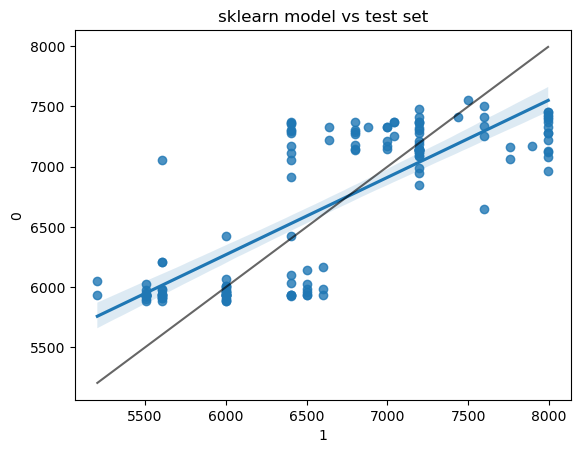

,0,1,error,mae,mse,r2
0,5933.049645,5603.710537,-329.339108,385.707502,478.690239,0.63762
1,7256.842105,7038.025522,-218.816584,385.707502,478.690239,0.63762
2,5974.368932,5603.710537,-370.658395,385.707502,478.690239,0.63762
3,5931.150442,5504.105334,-427.045108,385.707502,478.690239,0.63762
4,7214.395604,7197.393827,-17.001777,385.707502,478.690239,0.63762


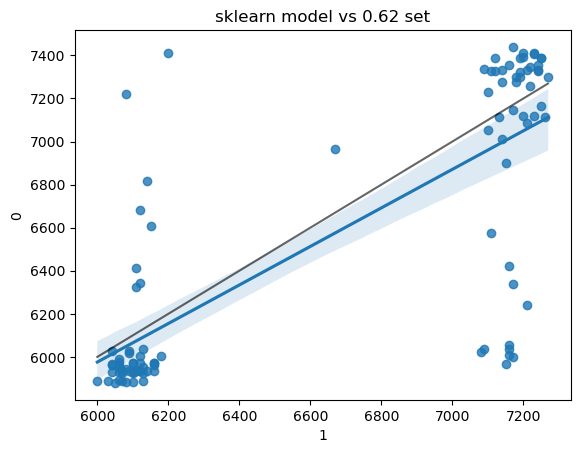

,0,1,error,mae,mse,r2
0,6035.468750,7160.0,1124.531250,274.832713,414.945915,0.406852
1,5889.531250,6130.0,240.468750,274.832713,414.945915,0.406852
2,5972.881356,6100.0,127.118644,274.832713,414.945915,0.406852
3,6898.181818,7150.0,251.818182,274.832713,414.945915,0.406852
4,5972.881356,6120.0,147.118644,274.832713,414.945915,0.406852


In [616]:
# sklearn benchmark
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR

# sk_model = SVR(C=10**4.5)
sk_model = AdaBoostRegressor(n_estimators=150)
sk_model.fit(scaler_x.transform(xfulltrain.reshape(-1, xfulltrain.shape[-1])).reshape(xfulltrain.shape).mean(2), scaler_y.transform(yfulltrain))

EvaluationPlot(sk_model, xtest.mean(2), ytest, 'sklearn model vs test set')
EvaluationPlot(sk_model, xsub.mean(2) , ytrue, 'sklearn model vs 0.62 set')

In [617]:
# submission_models = KFoldTraining(xsub, ytrue.round(1), False, False, model='convnet')
# submission_models = np.array(overfit_cheating_models)[:, 0]
# print(np.array(models_losses_transformer)[:, 1].mean())

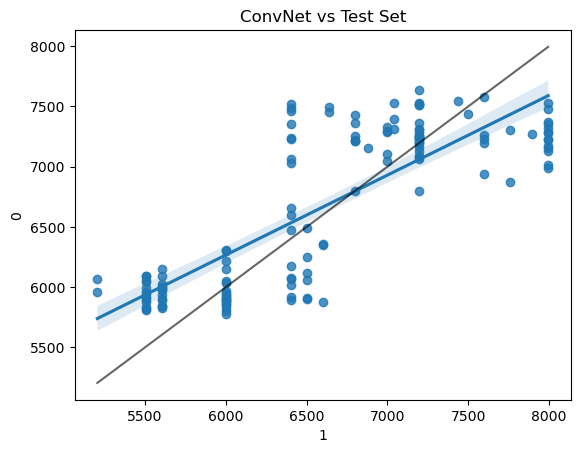

,0,1,error,mae,mse,r2
0,5842.561523,5603.710537,-238.850986,377.429337,466.64979,0.65562
1,7393.379395,7038.025522,-355.353873,377.429337,466.64979,0.65562
2,6150.925293,5603.710537,-547.214756,377.429337,466.64979,0.65562
3,5815.749512,5504.105334,-311.644177,377.429337,466.64979,0.65562
4,7278.833984,7197.393827,-81.440157,377.429337,466.64979,0.65562


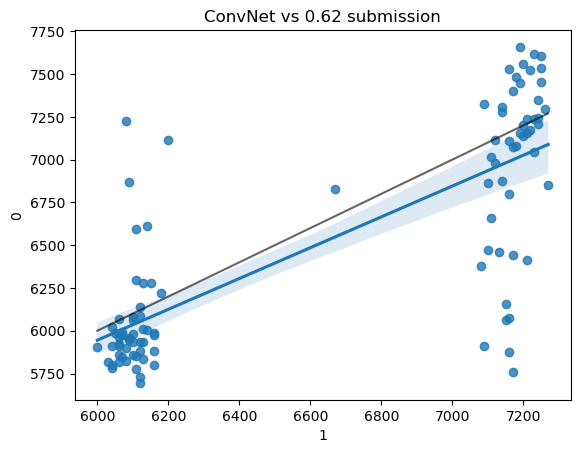

,0,1,error,mae,mse,r2
0,6074.478516,7160.0,1085.521484,291.413159,423.122121,0.383246
1,5832.571289,6130.0,297.428711,291.413159,423.122121,0.383246
2,6079.035156,6100.0,20.964844,291.413159,423.122121,0.383246
3,6155.327148,7150.0,994.672852,291.413159,423.122121,0.383246
4,5695.173340,6120.0,424.826660,291.413159,423.122121,0.383246


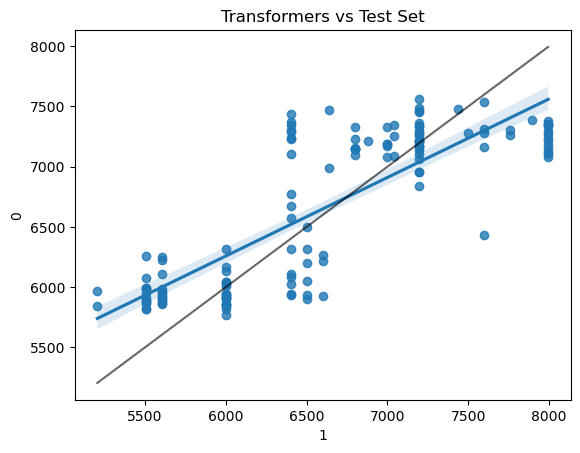

,0,1,error,mae,mse,r2
0,5866.398926,5603.710537,-262.688389,365.481929,453.551912,0.674681
1,7253.595215,7038.025522,-215.569693,365.481929,453.551912,0.674681
2,5863.833008,5603.710537,-260.122471,365.481929,453.551912,0.674681
3,5819.171875,5504.105334,-315.066541,365.481929,453.551912,0.674681
4,7208.875000,7197.393827,-11.481173,365.481929,453.551912,0.674681


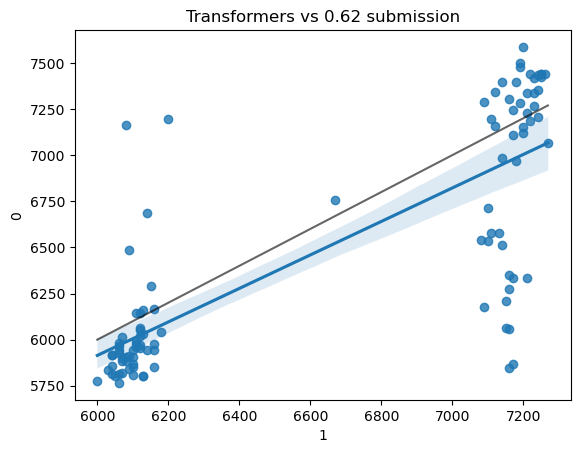

,0,1,error,mae,mse,r2
0,6056.846191,7160.0,1103.153809,290.642021,417.023571,0.400897
1,5801.498047,6130.0,328.501953,290.642021,417.023571,0.400897
2,5870.193359,6100.0,229.806641,290.642021,417.023571,0.400897
3,6210.428223,7150.0,939.571777,290.642021,417.023571,0.400897
4,5952.983398,6120.0,167.016602,290.642021,417.023571,0.400897


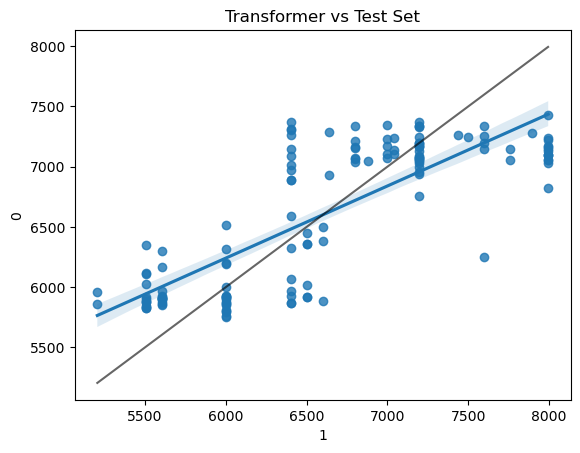

,0,1,error,mae,mse,r2
0,5901.805664,5603.710537,-298.095127,379.846848,474.441011,0.644025
1,7139.458984,7038.025522,-101.433463,379.846848,474.441011,0.644025
2,5853.522461,5603.710537,-249.811924,379.846848,474.441011,0.644025
3,5830.070312,5504.105334,-325.964978,379.846848,474.441011,0.644025
4,7175.193848,7197.393827,22.199979,379.846848,474.441011,0.644025


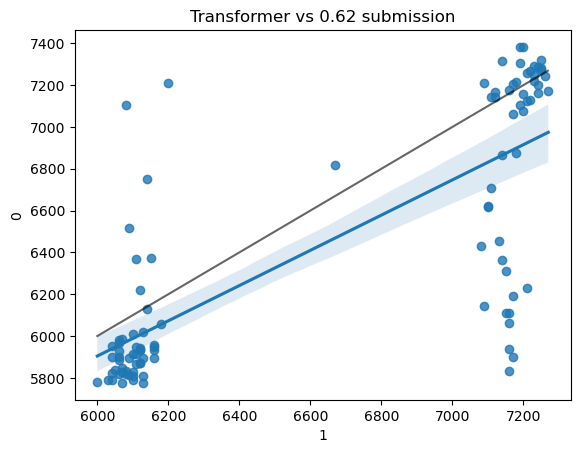

,0,1,error,mae,mse,r2
0,5938.117188,7160.0,1221.882812,296.196147,436.930147,0.342336
1,5807.492676,6130.0,322.507324,296.196147,436.930147,0.342336
2,5807.878418,6100.0,292.121582,296.196147,436.930147,0.342336
3,6312.012207,7150.0,837.987793,296.196147,436.930147,0.342336
4,5872.378906,6120.0,247.621094,296.196147,436.930147,0.342336


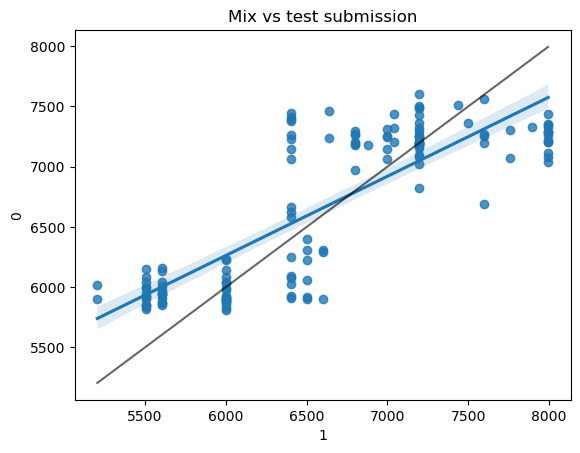

,0,1,error,mae,mse,r2
0,5854.480469,5603.710537,-250.769932,367.11264,454.507005,0.673309
1,7323.487305,7038.025522,-285.461783,367.11264,454.507005,0.673309
2,6007.379395,5603.710537,-403.668857,367.11264,454.507005,0.673309
3,5817.460938,5504.105334,-313.355603,367.11264,454.507005,0.673309
4,7243.854492,7197.393827,-46.460665,367.11264,454.507005,0.673309


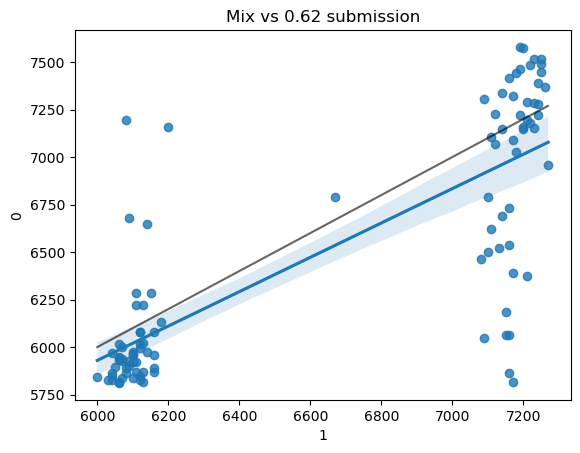

,0,1,error,mae,mse,r2
0,6065.662109,7160.0,1094.337891,284.65167,410.978165,0.418141
1,5817.034668,6130.0,312.965332,284.65167,410.978165,0.418141
2,5974.614258,6100.0,125.385742,284.65167,410.978165,0.418141
3,6182.877930,7150.0,967.122070,284.65167,410.978165,0.418141
4,5824.078613,6120.0,295.921387,284.65167,410.978165,0.418141


In [618]:
EvaluationPlot(models, xtest, ytest, 'ConvNet vs Test Set')
EvaluationPlot(models, xsub , ytrue, 'ConvNet vs 0.62 submission')

EvaluationPlot(models_tr, xtest, ytest, 'Transformers vs Test Set')
EvaluationPlot(models_tr, xsub , ytrue, 'Transformers vs 0.62 submission')

EvaluationPlot(model_tr, xtest, ytest, 'Transformer vs Test Set')
EvaluationPlot(model_tr, xsub , ytrue, 'Transformer vs 0.62 submission')

EvaluationPlot(np.append(models, models_tr), xtest, ytest, 'Mix vs test submission')
EvaluationPlot(np.append(models, models_tr), xsub , ytrue, 'Mix vs 0.62 submission')

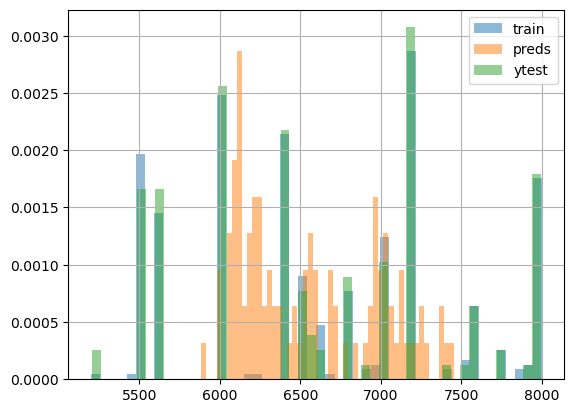

In [619]:
# Distribution of target variables
pd.Series(yfulltrain.squeeze()).hist(density=True, bins=50, label='train', alpha=0.5)
pd.Series(preds).hist(density=True, bins=50, label='preds', alpha=0.5)
pd.Series(scaler_y.inverse_transform(ytest.reshape(-1, 1)).squeeze()).hist(density=True, bins=50, label='ytest', alpha=0.5)
plt.legend()

## Retrain with full data

In [651]:
# Train KFolds with validation data
models = KFoldTraining(x, y, process_test=False, process_sub=False, model='transformer')

  0%|          | 0/800 [00:00<?, ?it/s]

50 time(s) has the accuracy not increased. Finishing training...49    
 best epoch: 232 training loss: 0.2855 best val_r2_loss: 0.337


  0%|          | 0/800 [00:00<?, ?it/s]

50 time(s) has the accuracy not increased. Finishing training...49    
 best epoch: 159 training loss: 0.269 best val_r2_loss: 0.356


  0%|          | 0/800 [00:00<?, ?it/s]

50 time(s) has the accuracy not increased. Finishing training...49    
 best epoch: 124 training loss: 0.3137 best val_r2_loss: 0.355


  0%|          | 0/800 [00:00<?, ?it/s]

50 time(s) has the accuracy not increased. Finishing training...49    
 best epoch: 89 training loss: 0.3162 best val_r2_loss: 0.3375


In [652]:
# Average validation loss
# print(np.array(models)[:, 1].mean())
np.array(models)[:, 1].mean()

0.3464090067893266

In [653]:
# Train once on all data
model_full = FullDataTraining(x, y, process_test=False, process_sub=False, n_epochs=150)

  0%|          | 0/150 [00:00<?, ?it/s]

Seed: 207795 msq: 0.5206 r2: 0.476

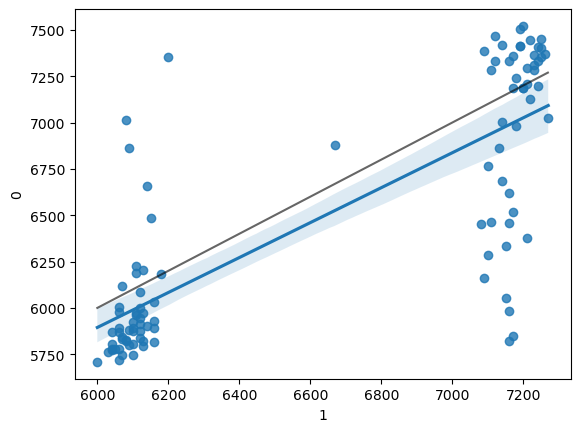

,0,1,error,mae,mse,r2
0,5983.059082,7160.0,1176.940918,310.544775,425.406404,0.376569
1,5793.409668,6130.0,336.590332,310.544775,425.406404,0.376569
2,5875.635742,6100.0,224.364258,310.544775,425.406404,0.376569
3,6334.966309,7150.0,815.033691,310.544775,425.406404,0.376569
4,5838.801758,6120.0,281.198242,310.544775,425.406404,0.376569


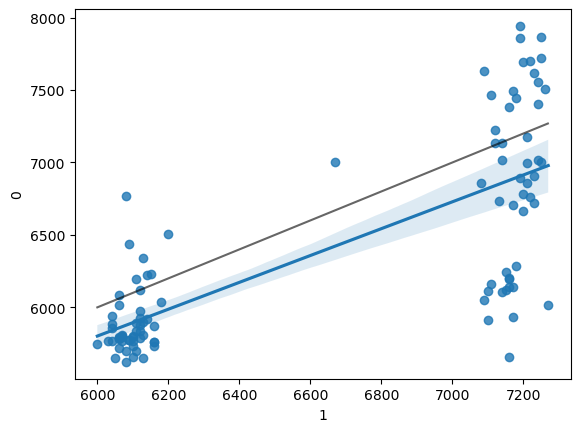

,0,1,error,mae,mse,r2
0,6138.451172,7160.0,1021.548828,415.313076,520.421859,0.066979
1,5651.584473,6130.0,478.415527,415.313076,520.421859,0.066979
2,5792.240723,6100.0,307.759277,415.313076,520.421859,0.066979
3,6118.122559,7150.0,1031.877441,415.313076,520.421859,0.066979
4,5835.703125,6120.0,284.296875,415.313076,520.421859,0.066979


In [655]:
EvaluationPlot(np.array(models)[:, 0], xsub, ytrue)
EvaluationPlot(model_full, xsub, ytrue)

# Make predictions and submit

In [656]:
kfold_preds = []
for m in np.array(models)[:, 0]:
    kfold_preds.append(m(xsub.to('cuda')).cpu().detach().numpy())

In [657]:
sub_preds = np.array(kfold_preds).mean(0)
# sub_preds = model_full(xsub.to('cuda')).cpu().detach().numpy()
sub_preds = scaler_y.inverse_transform(sub_preds).squeeze()

sub_preds

array([5983.059 , 5793.4097, 5875.6357, 6334.9663, 5838.802 , 6163.015 ,
       5890.7456, 5946.6655, 7241.3438, 7331.6367, 7354.8096, 5804.381 ,
       5931.4395, 6002.09  , 6655.969 , 7294.3745, 5759.897 , 6085.6074,
       5745.5156, 6762.9795, 7312.645 , 6006.153 , 6377.354 , 6116.505 ,
       6519.7153, 7360.9233, 6452.534 , 5978.7373, 5876.349 , 6034.54  ,
       5924.1436, 5778.036 , 7128.96  , 6617.213 , 7185.6313, 6464.903 ,
       5776.0474, 5817.91  , 6876.103 , 5799.3413, 7383.88  , 5803.858 ,
       5915.441 , 7444.772 , 5821.679 , 5971.394 , 5845.731 , 7188.3833,
       5869.651 , 6863.217 , 7003.4546, 7331.749 , 6187.22  , 7368.1685,
       6223.884 , 7450.6577, 7365.497 , 7281.5737, 5743.6665, 5972.136 ,
       5961.681 , 5821.761 , 5819.095 , 5774.721 , 6682.7876, 7520.931 ,
       6861.9   , 7413.6763, 7506.282 , 5882.8413, 5872.7046, 7187.389 ,
       5891.5137, 5902.7593, 7354.942 , 5825.301 , 5847.9375, 5833.6206,
       7399.184 , 7407.319 , 5708.6934, 7197.59  , 

In [658]:
submission_df = pd.read_csv('Challenge_2_submission_template.csv')
submission_df['Predicted Rice Yield (kg/ha)'] = sub_preds
submission_df.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,5983.059082
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,5793.409668
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,5875.635742
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,6334.966309
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,5838.801758


In [1082]:
submission_df.to_csv('Version 13.csv', index=False)